In [1]:
import distribution_test as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from sklearn.preprocessing import StandardScaler
from glob import glob
from tqdm import tqdm

import os
try:
    WORKING_DIR_FLAG
except NameError:
    os.chdir('../../')
    WORKING_DIR_FLAG = True
    
from scripts.util.running_statistic import running_statistic
from scripts.util.umaps import fit_umap
from scripts.preprocessing.prepare import DatasetMatcher
get_matched_masks = DatasetMatcher.get_matched_masks

HSC_color = 'grey'
HSC_TNG50_color = 'bisque'
HSC_TNG100_color = 'aqua'
TNG50_color = 'orange'
TNG100_color = 'blue'

palette = {'HSC_TNG50': HSC_TNG50_color,
           'HSC_TNG100': HSC_TNG100_color,
           'TNG50': TNG50_color,
           'TNG100': TNG100_color,
           'HSC': HSC_color,
           'TNG50_TNG100': 'green'}

In [2]:
def load_representation(path):
    with open(path, 'rb') as f:
        rep = np.load(f)

    scaler = StandardScaler()
    scaler.fit(rep)
    rep = scaler.transform(rep)
    
    return rep

optuna_files = glob('./postprocessing/optuna/*')
representation_path = './postprocessing/representation.npy'

rep = load_representation(representation_path)
df = pd.read_csv('./dataset/m_test.csv')

HSC_arcsec_per_pixel = 0.168
df["petro_90_light"] = df['petro_90_light'].multiply(HSC_arcsec_per_pixel)

optuna_rep = []

for path in tqdm(optuna_files):
    optuna_rep.append(load_representation(path))


100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


In the first Section we split every dataset into 2 subsets to investigate the distribution of the distances and to get the scaling factor

In [3]:
indices_HSC_TNG100 = np.argwhere((df['matched_set'] == 'HSC_TNG100').to_numpy())[:,0]
indices_HSC_TNG50 = np.argwhere((df['matched_set'] == 'HSC_TNG50').to_numpy())[:,0]
indices_TNG100 = np.argwhere((df['dataset'] == 'HSC_TNG100').to_numpy())[:,0]
indices_TNG50 = np.argwhere((df['dataset'] == 'HSC_TNG50').to_numpy())[:,0]

np.random.shuffle(indices_HSC_TNG100)
np.random.shuffle(indices_HSC_TNG50)
np.random.shuffle(indices_TNG100)
np.random.shuffle(indices_TNG50)

split_indices_HSC_TNG100 = np.array_split(indices_HSC_TNG100, 2)
split_indices_HSC_TNG50 = np.array_split(indices_HSC_TNG50, 2)
split_indices_TNG100 = np.array_split(indices_TNG100, 2)
split_indices_TNG50 = np.array_split(indices_TNG50, 2)

def split(rep):
    #TNG100 - HSC
    x_list = [rep[split_indices_HSC_TNG100[0]], rep[split_indices_HSC_TNG100[1]], rep[split_indices_TNG100[0]], rep[split_indices_TNG100[1]]]
    df_list = [df.iloc[split_indices_HSC_TNG100[0]], df.iloc[split_indices_HSC_TNG100[1]], df.iloc[split_indices_TNG100[0]], df.iloc[split_indices_TNG100[1]]]
    x_list, _ = dt.DistributionTest.reshape_inputs(x_list,df_list)
    rep_HSC_TNG100_0 = x_list[0]
    rep_HSC_TNG100_1 = x_list[1]
    rep_TNG100_0 = x_list[2]
    rep_TNG100_1 = x_list[3]

    #TNG50 - HSC
    x_list = [rep[split_indices_HSC_TNG50[0]], rep[split_indices_HSC_TNG50[1]], rep[split_indices_TNG50[0]], rep[split_indices_TNG50[1]]]
    df_list = [df.iloc[split_indices_HSC_TNG50[0]], df.iloc[split_indices_HSC_TNG50[1]], df.iloc[split_indices_TNG50[0]], df.iloc[split_indices_TNG50[1]]]

    x_list, _ = dt.DistributionTest.reshape_inputs(x_list,df_list)
    rep_HSC_TNG50_0 = x_list[0]
    rep_HSC_TNG50_1 = x_list[1]
    rep_TNG50_0 = x_list[2]
    rep_TNG50_1 = x_list[3]

    #TNG50 - TNG100 with additional matching (we originaly matched them only to HSC)
    x_list = [rep[split_indices_TNG50[0]], rep[split_indices_TNG50[1]], rep[split_indices_TNG100[0]], rep[split_indices_TNG100[1]]]
    df_list = [df.iloc[split_indices_TNG50[0]], df.iloc[split_indices_TNG50[1]], df.iloc[split_indices_TNG100[0]], df.iloc[split_indices_TNG100[1]]]

    x_list, df_list = dt.DistributionTest.reshape_inputs(x_list,df_list)
    
    fields = ['z', 'i_band_mag_dust_apparent', 'petro_90_light']
    
    df_TNG50_TNG100_0 = df_list[0]
    df_TNG50_TNG100_1 = df_list[1]
    df_TNG100_TNG50_0 = df_list[2]
    df_TNG100_TNG50_1 = df_list[3]
    
    null = [np.nan]*len(df_TNG100_TNG50_0)
    mask_1, mask_2, _, _ = get_matched_masks(df_TNG100_TNG50_0[fields], df_TNG50_TNG100_0[fields], null, null)
    rep_TNG50_TNG100_0 = x_list[0][mask_2]
    rep_TNG100_TNG50_0 = x_list[2][mask_1]
    
    null = [np.nan]*len(df_TNG100_TNG50_1)
    mask_1, mask_2, _, _ = get_matched_masks(df_TNG100_TNG50_1[fields], df_TNG50_TNG100_1[fields], null, null)
    rep_TNG50_TNG100_1 = x_list[1][mask_2]
    rep_TNG100_TNG50_1 = x_list[3][mask_1]
    
    return (rep_HSC_TNG100_0,
            rep_HSC_TNG100_1,
            rep_TNG100_0,
            rep_TNG100_1,
            rep_HSC_TNG50_0,
            rep_HSC_TNG50_1,
            rep_TNG50_0,
            rep_TNG50_1,
            rep_TNG50_TNG100_0,
            rep_TNG50_TNG100_1,
            rep_TNG100_TNG50_0,
            rep_TNG100_TNG50_1)
            

rep_split = split(rep)

rep_optuna_split = []
for r in tqdm(optuna_rep):
    rep_optuna_split.append(split(r))

100%|██████████| 2860/2860 [00:00<00:00, 16949.89it/s]


Number of matched galaxies: 1840 / 2860


100%|██████████| 2860/2860 [00:00<00:00, 17327.08it/s]


Number of matched galaxies: 1795 / 2860


100%|██████████| 2860/2860 [00:00<00:00, 16947.88it/s]


Number of matched galaxies: 1840 / 2860



  7%|▋         | 1/15 [00:00<00:05,  2.44it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 16810.79it/s]


Number of matched galaxies: 1840 / 2860



 13%|█▎        | 2/15 [00:00<00:05,  2.45it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 16847.69it/s]


Number of matched galaxies: 1840 / 2860



 20%|██        | 3/15 [00:01<00:04,  2.44it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 16900.36it/s]


Number of matched galaxies: 1840 / 2860



 27%|██▋       | 4/15 [00:01<00:04,  2.45it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 16894.84it/s]


Number of matched galaxies: 1840 / 2860



 33%|███▎      | 5/15 [00:02<00:04,  2.49it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 16861.50it/s]


Number of matched galaxies: 1840 / 2860



 40%|████      | 6/15 [00:02<00:03,  2.50it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 16810.30it/s]


Number of matched galaxies: 1840 / 2860



 47%|████▋     | 7/15 [00:02<00:03,  2.52it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 16821.00it/s]


Number of matched galaxies: 1840 / 2860



 53%|█████▎    | 8/15 [00:03<00:02,  2.52it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 16771.14it/s]


Number of matched galaxies: 1840 / 2860



 60%|██████    | 9/15 [00:03<00:02,  2.52it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 16807.21it/s]


Number of matched galaxies: 1840 / 2860



 67%|██████▋   | 10/15 [00:03<00:01,  2.53it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 17087.27it/s]


Number of matched galaxies: 1840 / 2860



 73%|███████▎  | 11/15 [00:04<00:01,  2.55it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 16930.71it/s]


Number of matched galaxies: 1840 / 2860



 80%|████████  | 12/15 [00:04<00:01,  2.55it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 17050.43it/s]


Number of matched galaxies: 1840 / 2860



 87%|████████▋ | 13/15 [00:05<00:00,  2.56it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 17001.57it/s]


Number of matched galaxies: 1840 / 2860



 93%|█████████▎| 14/15 [00:05<00:00,  2.56it/s]

Number of matched galaxies: 1795 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 16953.05it/s]


Number of matched galaxies: 1840 / 2860



100%|██████████| 15/15 [00:05<00:00,  2.53it/s]

Number of matched galaxies: 1795 / 2860


In [4]:
def rep2score(rep_split, n):
    
    (rep_HSC_TNG100_0,
     rep_HSC_TNG100_1,
     rep_TNG100_0,
     rep_TNG100_1,
     rep_HSC_TNG50_0,
     rep_HSC_TNG50_1,
     rep_TNG50_0,
     rep_TNG50_1,
     rep_TNG50_TNG100_0,
     rep_TNG50_TNG100_1,
     rep_TNG100_TNG50_0,
     rep_TNG100_TNG50_1) = rep_split
    
    
    mnnd_TNG100 = dt.MeanNormalizedNeighborDistance(rep_TNG100_0, n_neighbor=n, p=1)
    score_TNG100_TNG100 = mnnd_TNG100.get_normalized_neighbor_distances(rep_TNG100_1)
    score_TNG100_HSC = mnnd_TNG100.get_normalized_neighbor_distances(rep_HSC_TNG100_0)

    mnnd_TNG100 = dt.MeanNormalizedNeighborDistance(rep_TNG100_TNG50_0, n_neighbor=n, p=1)
    score_TNG100_TNG50 = mnnd_TNG100.get_normalized_neighbor_distances(rep_TNG50_TNG100_0)

    mnnd_TNG50 = dt.MeanNormalizedNeighborDistance(rep_TNG50_TNG100_0, n_neighbor=n, p=1)
    score_TNG50_TNG100 = mnnd_TNG50.get_normalized_neighbor_distances(rep_TNG100_TNG50_0)

    mnnd_TNG50 = dt.MeanNormalizedNeighborDistance(rep_TNG50_0, n_neighbor=n, p=1)
    score_TNG50_HSC = mnnd_TNG50.get_normalized_neighbor_distances(rep_HSC_TNG50_0)
    score_TNG50_TNG50 = mnnd_TNG50.get_normalized_neighbor_distances(rep_TNG50_1)

    mnnd_HSC = dt.MeanNormalizedNeighborDistance(rep_HSC_TNG100_0, n_neighbor=n, p=1)
    score_HSC_HSC = mnnd_HSC.get_normalized_neighbor_distances(rep_HSC_TNG100_1)
    score_HSC_TNG100 = mnnd_HSC.get_normalized_neighbor_distances(rep_TNG100_0)

    mnnd_HSC = dt.MeanNormalizedNeighborDistance(rep_HSC_TNG50_0, n_neighbor=n, p=1)
    score_HSC_TNG50 = mnnd_HSC.get_normalized_neighbor_distances(rep_TNG50_0)
    
    return (score_TNG100_TNG100,
            score_TNG100_HSC,
            score_TNG100_TNG50,
            score_TNG50_TNG100,
            score_TNG50_HSC,
            score_TNG50_TNG50,
            score_HSC_HSC,
            score_HSC_TNG100,
            score_HSC_TNG50)

score = rep2score(rep_split, n=8)
score_4 = rep2score(rep_split, n=4)
score_16 = rep2score(rep_split, n=16)
score_32 = rep2score(rep_split, n=32)

score_optuna = []
for r in tqdm(rep_optuna_split):
    score_optuna.append(rep2score(r, n=8))

100%|██████████| 15/15 [07:16<00:00, 29.07s/it]


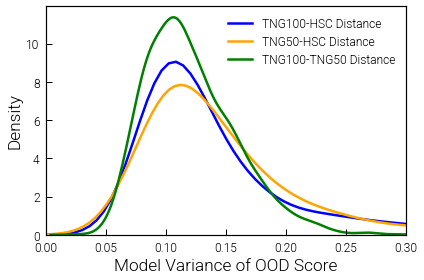

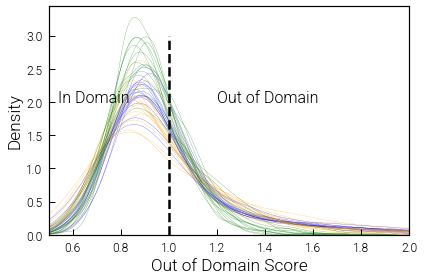

In [5]:
lw = 2.5

sns.kdeplot(x=np.std([s[1]/1.146 for s in score_optuna], axis=0), color=palette['TNG100'], lw=lw)
#sns.kdeplot(x=np.std([s[7]/1.146 for s in score_optuna], axis=0), color=palette['TNG100'], linestyle='dotted', lw=lw)
sns.kdeplot(x=np.std([s[4]/1.146 for s in score_optuna], axis=0), color=palette['TNG50'], lw=lw)
#sns.kdeplot(x=np.std([s[8]/1.146 for s in score_optuna], axis=0), color=palette['TNG50'], linestyle='dotted', lw=lw)
sns.kdeplot(x=np.std([s[2]/1.146 for s in score_optuna], axis=0), color=palette['TNG50_TNG100'], lw=lw)
#sns.kdeplot(x=np.std([s[3]/1.146 for s in score_optuna], axis=0), color=palette['TNG50_TNG100'], linestyle='dotted', lw=lw)
#sns.kdeplot(x=np.std([s[6]/1.146 for s in score_optuna], axis=0), color=palette['HSC'], linestyle='dashed', lw=lw)

#plt.legend(labels=['TNG100-HSC Distance', 'HSC-TNG100 Distance', 'TNG50-HSC Distance', 'HSC-TNG50 Distance', 'TNG100-TNG50 Distance', 'TNG50-TNG100 Distance', 'HSC Self Distance'])
plt.legend(labels=['TNG100-HSC Distance', 'TNG50-HSC Distance', 'TNG100-TNG50 Distance', 'HSC Self Distance'])
plt.xlabel('Model Variance of OOD Score')
plt.savefig('./temp/ood_model_variance.pdf')
plt.xlim(0,0.3)
plt.show()

index_list = [1, 4, 3]
set_list = ['TNG100', 'TNG50', 'TNG50_TNG100']

for i, c in zip(index_list, set_list):
    for s in score_optuna:
        sns.kdeplot(x=s[i]/1.146 , color=palette[c], lw=0.2)
        
plt.xlim(0.5,2)
plt.plot([1,1],[0,3],'k--', lw=lw)
plt.text(0.54, 2, 'In Domain', color='k', size=16)
plt.text(1.2, 2, 'Out of Domain', color='k', size=16)
plt.xlabel('Out of Domain Score')
plt.ylabel('Density')
plt.savefig('./temp/ood_model_variation.pdf')
plt.show()
        

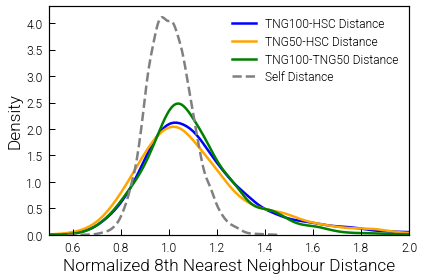

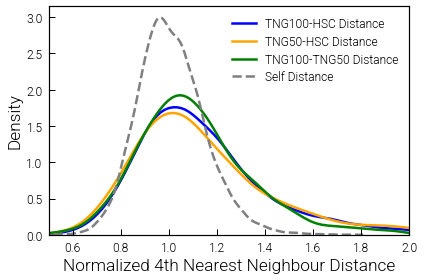

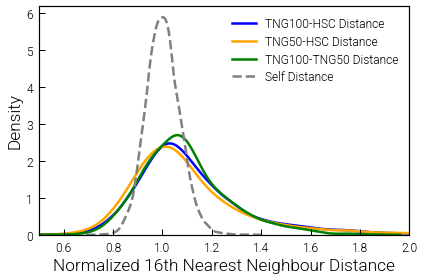

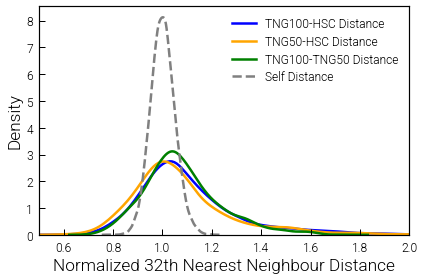

In [6]:
def plot_distances(score, label = 'Normalized 8th Nearest Neighbour Distance', save_path = 'similarity_distribution.pdf'):
    (score_TNG100_TNG100,
     score_TNG100_HSC,
     score_TNG100_TNG50,
     score_TNG50_TNG100,
     score_TNG50_HSC,
     score_TNG50_TNG50,
     score_HSC_HSC,
     score_HSC_TNG100,
     score_HSC_TNG50) = score

    lw = 2.5
    sns.kdeplot(x=score_TNG100_HSC, color=palette['TNG100'], lw=lw)
    #sns.kdeplot(x=score_HSC_TNG100, color=palette['TNG100'], linestyle='dotted', lw=lw)
    sns.kdeplot(x=score_TNG50_HSC, color=palette['TNG50'], lw=lw)
    #sns.kdeplot(x=score_HSC_TNG50, color=palette['TNG50'], linestyle='dotted', lw=lw)

    sns.kdeplot(x=score_TNG100_TNG50, color=palette['TNG50_TNG100'], lw=lw)
    #sns.kdeplot(x=score_TNG50_TNG100, color=palette['TNG50_TNG100'], linestyle='dotted', lw=lw)

    sns.kdeplot(x=score_HSC_HSC, color=palette['HSC'], linestyle='dashed', lw=lw)
    #sns.kdeplot(x=score_TNG100_TNG100, color=palette['HSC'], linestyle='dotted', lw=lw)
    #sns.kdeplot(x=score_TNG50_TNG50, color=palette['HSC'], linestyle='dashdot', lw=lw)


    #plt.legend(labels=['TNG100-HSC Distance', 'HSC-TNG100 Distance', 'TNG50-HSC Distance', 'HSC-TNG50 Distance', 'TNG100-TNG50 Distance', 'TNG50-TNG100 Distance', 'HSC Self Distance','TNG100 Self Distance','TNG50 Self Distance'])
    plt.legend(labels=['TNG100-HSC Distance', 'TNG50-HSC Distance', 'TNG100-TNG50 Distance', 'Self Distance'], loc ="upper right")


    plt.xlim(0.5,2)
    plt.xlabel(label)
    plt.ylabel('Density')
    plt.savefig('./temp/' + save_path)
    plt.show()
    
plot_distances(score)
plot_distances(score_4, label = 'Normalized 4th Nearest Neighbour Distance', save_path = 'similarity_distribution_4.pdf')
plot_distances(score_16, label = 'Normalized 16th Nearest Neighbour Distance', save_path = 'similarity_distribution_16.pdf')
plot_distances(score_32, label = 'Normalized 32th Nearest Neighbour Distance', save_path = 'similarity_distribution_32.pdf')
#print('optuna')
#for i in range(len(score_optuna)):
#    plot_distances(score_optuna[i], save_path = 'similarity_distribution_run_%02d.pdf'%(i))

In [7]:
(score_TNG100_TNG100,
 score_TNG100_HSC,
 score_TNG100_TNG50,
 score_TNG50_TNG100,
 score_TNG50_HSC,
 score_TNG50_TNG50,
 score_HSC_HSC,
 score_HSC_TNG100,
 score_HSC_TNG50) = score

factor_TNG100 = np.quantile(score_TNG100_TNG100, 0.95)
factor_TNG50 = np.quantile(score_TNG50_TNG50, 0.95)
factor_HSC = np.quantile(score_HSC_HSC, 0.95)

print(factor_TNG100)
print(factor_TNG50)
print(factor_HSC)

score_TNG100_HSC = score_TNG100_HSC/factor_TNG100
score_HSC_TNG100 = score_HSC_TNG100/factor_HSC
score_TNG50_HSC = score_TNG50_HSC/factor_TNG50
score_HSC_TNG50 = score_HSC_TNG50/factor_HSC

score_TNG100_TNG50 = score_TNG100_TNG50/factor_TNG100
score_TNG50_TNG100 = score_TNG50_TNG100/factor_TNG50
score_HSC_HSC = score_HSC_HSC/factor_HSC

1.1705631958923104
1.192001678682238
1.1700142621059284


0.335171663818549
0.2881118881118881
0.28152173913043477
0.05002330278079851


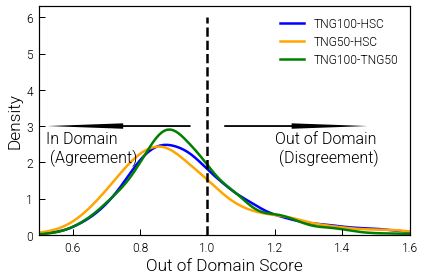

In [8]:
lw = 2.5

sns.kdeplot(x=score_TNG100_HSC, color=palette['TNG100'], lw=lw)
#sns.kdeplot(x=score_HSC_TNG100, color=palette['TNG100'], linestyle='dotted', lw=lw)
sns.kdeplot(x=score_TNG50_HSC, color=palette['TNG50'], lw=lw)
#sns.kdeplot(x=score_HSC_TNG50, color=palette['TNG50'], linestyle='dotted', lw=lw)
print(np.sum(score_TNG100_HSC>1.0)/len(score_TNG100_HSC))
#print(np.sum(score_HSC_TNG100>1.0)/len(score_HSC_TNG100))
print(np.sum(score_TNG50_HSC>1.0)/len(score_TNG50_HSC))
#print(np.sum(score_HSC_TNG50>1.0)/len(score_HSC_TNG50))


sns.kdeplot(x=score_TNG100_TNG50, color=palette['TNG50_TNG100'], lw=lw)
#sns.kdeplot(x=score_TNG50_TNG100, color=palette['TNG50_TNG100'], linestyle='dotted', lw=lw)
print(np.sum(score_TNG100_TNG50>1.0)/len(score_TNG100_TNG50))
#print(np.sum(score_TNG50_TNG100>1.0)/len(score_TNG50_TNG100))

#sns.kdeplot(x=score_HSC_HSC, color=palette['HSC'], linestyle='dashed', lw=lw)
print(np.sum(score_HSC_HSC>1.0)/len(score_HSC_HSC))

#plt.legend(labels=['TNG100-HSC', 'HSC-TNG100', 'TNG50-HSC', 'HSC-TNG50', 'TNG100-TNG50', 'TNG50-TNG100', 'HSC-HSC'])
plt.legend(labels=['TNG100-HSC', 'TNG50-HSC', 'TNG100-TNG50'])

plt.plot([1,1],[0,6],'k--', lw=lw)
plt.text(0.52, 2, 'In Domain \n (Agreement)', color='k', size=16)
plt.text(1.2, 2, 'Out of Domain \n (Disgreement)', color='k', size=16)
plt.arrow(0.95, 3, -0.2, 0, width=0.05, color='k')
plt.arrow(1.05, 3, 0.2, 0, width=0.05, color='k')

plt.xlim(0.5,1.6)
plt.xlabel('Out of Domain Score')
plt.ylabel('Density')
plt.savefig('./temp/similarity_distribution_scaled.pdf')
plt.show()

In [9]:
indices_HSC_TNG100 = np.argwhere((df['matched_set'] == 'HSC_TNG100').to_numpy())[:,0]
indices_HSC_TNG50 = np.argwhere((df['matched_set'] == 'HSC_TNG50').to_numpy())[:,0]
indices_TNG100 = np.argwhere((df['dataset'] == 'HSC_TNG100').to_numpy())[:,0]
indices_TNG50 = np.argwhere((df['dataset'] == 'HSC_TNG50').to_numpy())[:,0]

np.random.shuffle(indices_HSC_TNG100)
np.random.shuffle(indices_HSC_TNG50)
np.random.shuffle(indices_TNG100)
np.random.shuffle(indices_TNG50)


#HSC -- TNG100
x_list = [rep[indices_HSC_TNG100], rep[indices_TNG100]]
df_list = [df.iloc[indices_HSC_TNG100], df.iloc[indices_TNG100]]

x_list, df_list = dt.DistributionTest.reshape_inputs(x_list,df_list)

rep_HSC_TNG100 = x_list[0]
rep_TNG100_HSC = x_list[1]
df_HSC_TNG100 = df_list[0]
df_TNG100_HSC = df_list[1]


#HSC -- TNG50
x_list = [rep[indices_HSC_TNG50], rep[indices_TNG50]]
df_list = [df.iloc[indices_HSC_TNG50], df.iloc[indices_TNG50]]

x_list, df_list = dt.DistributionTest.reshape_inputs(x_list,df_list)

rep_HSC_TNG50 = x_list[0]
rep_TNG50_HSC = x_list[1]
df_HSC_TNG50 = df_list[0]
df_TNG50_HSC = df_list[1]


#TNG100 -- TNG50
x_list = [rep[indices_TNG100], rep[indices_TNG50]]
df_list = [df.iloc[indices_TNG100], df.iloc[indices_TNG50]]

x_list, df_list = dt.DistributionTest.reshape_inputs(x_list,df_list)

rep_TNG100_TNG50 = x_list[0]
rep_TNG50_TNG100 = x_list[1]
df_TNG100_TNG50 = df_list[0]
df_TNG50_TNG100 = df_list[1]

assert rep_HSC_TNG50.shape[0] == len(df_HSC_TNG50)
assert rep_HSC_TNG100.shape[0] == len(df_HSC_TNG100)
assert rep_TNG50_HSC.shape[0] == len(df_TNG50_HSC)
assert rep_TNG100_HSC.shape[0] == len(df_TNG100_HSC)
assert rep_TNG50_TNG100.shape[0] == len(df_TNG50_TNG100)
assert rep_TNG100_TNG50.shape[0] == len(df_TNG100_TNG50)

In [10]:
mnnd_TNG100 = dt.MeanNormalizedNeighborDistance(rep_TNG100_HSC, n_neighbor=8, p=1)
score_TNG100_HSC = mnnd_TNG100.get_normalized_neighbor_distances(rep_HSC_TNG100)/factor_TNG100

mnnd_TNG50 = dt.MeanNormalizedNeighborDistance(rep_TNG50_HSC, n_neighbor=8, p=1)
score_TNG50_HSC = mnnd_TNG50.get_normalized_neighbor_distances(rep_HSC_TNG50)/factor_TNG50

mnnd_HSC = dt.MeanNormalizedNeighborDistance(rep_HSC_TNG100, n_neighbor=8, p=1)
score_HSC_TNG100 = mnnd_HSC.get_normalized_neighbor_distances(rep_TNG100_HSC)/factor_HSC

mnnd_HSC = dt.MeanNormalizedNeighborDistance(rep_HSC_TNG50, n_neighbor=8, p=1)
score_HSC_TNG50 = mnnd_HSC.get_normalized_neighbor_distances(rep_TNG50_HSC)/factor_HSC

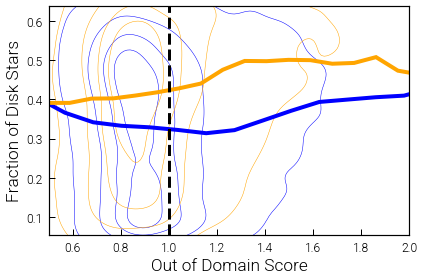

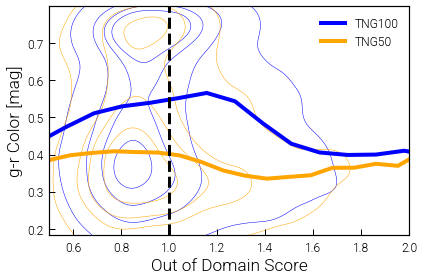

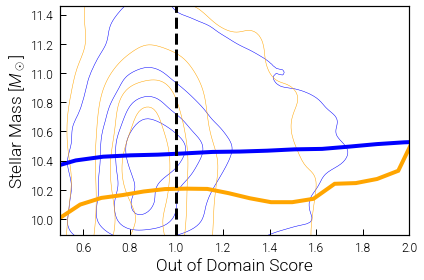

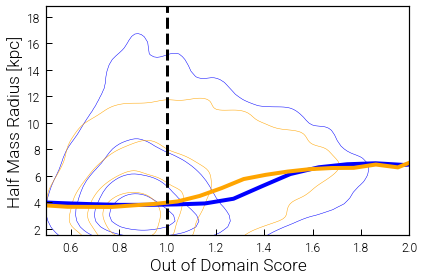

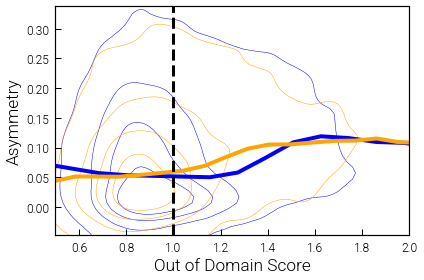

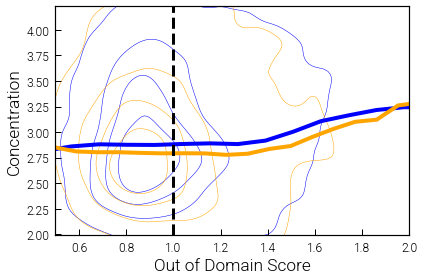

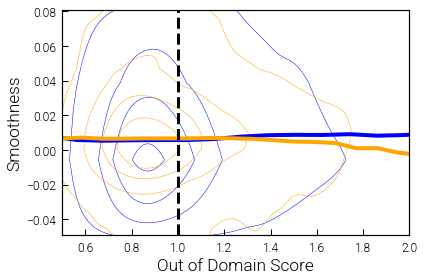

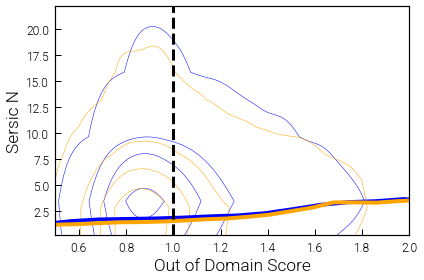

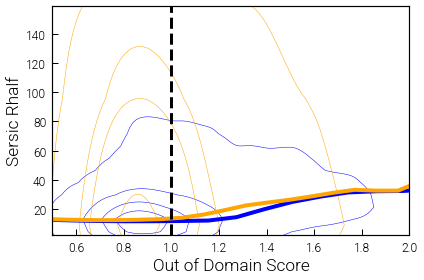

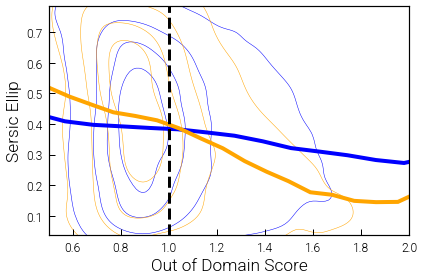

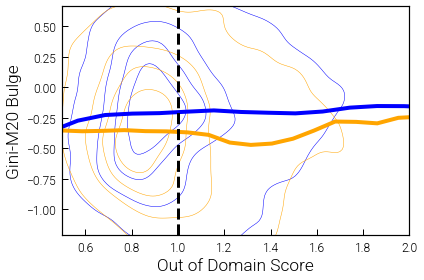

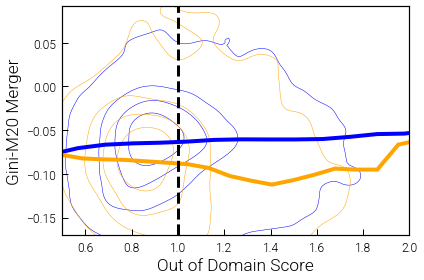

In [11]:
label_TNG =['fraction_disk_stars', 'color',  'mass', 'half_mass_rad_physical', 'asymmetry', 'concentration', 'smoothness', 'sersic_n', 'sersic_rhalf', 'sersic_ellip', 'gini_m20_bulge', 'gini_m20_merger']
label_TNG_human =['Fraction of Disk Stars', 'g-r Color [mag]', 'Stellar Mass [$M_\odot$]', 'Half Mass Radius [kpc]', 'Asymmetry', 'Concentration', 'Smoothness', 'Sersic N', 'Sersic Rhalf', 'Sersic Ellip', 'Gini-M20 Bulge', 'Gini-M20 Merger']

NUM_BINS = 20

for l, lh in zip(label_TNG, label_TNG_human):
    try:
        
        sns.kdeplot(x=score_TNG100_HSC, y=df_TNG100_HSC[l], levels=5, linewidths=0.5, color=palette['TNG100'], linestyles='solid')
        sns.kdeplot(x=score_TNG50_HSC, y=df_TNG50_HSC[l], levels=5, linewidths=0.5, color=palette['TNG50'], linestyles='solid')
        
        bin_statistic, bin_edges, binnumber = running_statistic(score_TNG100_HSC, df_TNG100_HSC[l], statistic=np.nanmedian, bins=NUM_BINS)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        plt.plot(bin_centers,bin_statistic, c=palette['TNG100'], lw=4, label ='TNG100')
        
        bin_statistic, bin_edges, binnumber = running_statistic(score_TNG50_HSC, df_TNG50_HSC[l], statistic=np.nanmedian, bins=NUM_BINS)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        plt.plot(bin_centers, bin_statistic, c=palette['TNG50'], lw=4, label ='TNG50')
        
        y_min = np.nanquantile(df_TNG100_HSC[l], q=0.01)
        y_max = np.nanquantile(df_TNG100_HSC[l], q=0.99)
        
        plt.plot([1,1], [y_min, y_max], 'k--', lw=3)
        
        if l == 'color':
            plt.legend()
        
        plt.ylabel(lh)
        plt.xlabel('Out of Domain Score')
        plt.xlim(0.5, 2)
        plt.ylim(y_min, y_max)
        plt.savefig(f'./temp/similarity_score_{l}.pdf')
        plt.show()
        
    except Exception as e:
        print(e)

In [24]:
model = fit_umap(rep, n_neighbors=100, min_dist=0.5)
u_TNG100 = model.transform(rep_TNG100_HSC)
u_TNG50 = model.transform(rep_TNG50_HSC)
u_HSC_TNG50 = model.transform(rep_HSC_TNG50)
u_HSC_TNG100 = model.transform(rep_HSC_TNG100)

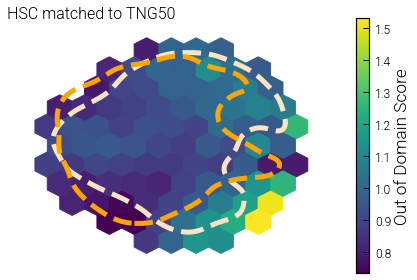

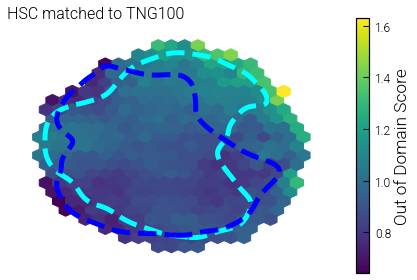

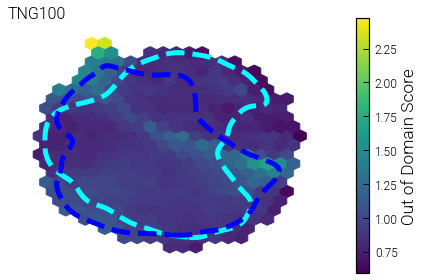

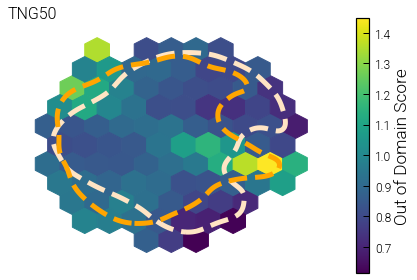

In [27]:
u_dict = {'HSC_TNG50': u_HSC_TNG50, 'HSC_TNG100': u_HSC_TNG100, 'TNG100': u_TNG100, 'TNG50': u_TNG50}
gridsize_dict = {'HSC_TNG50': 10, 'HSC_TNG100': 20, 'TNG100': 20, 'TNG50': 10}
score_dict = {'TNG100':score_TNG100_HSC, 'TNG50':score_TNG50_HSC, 'HSC_TNG100':score_HSC_TNG100, 'HSC_TNG50':score_HSC_TNG50}
label_dict = {'TNG100':'TNG100', 'TNG50':'TNG50', 'HSC_TNG100':'HSC matched to TNG100', 'HSC_TNG50':'HSC matched to TNG50'}

set_list = ['HSC_TNG50', 'HSC_TNG100', 'TNG100', 'TNG50']
kde_dict = {'HSC_TNG50': ['HSC_TNG50', 'TNG50'],
            'HSC_TNG100': ['HSC_TNG100', 'TNG100'],
            'TNG50': ['HSC_TNG50', 'TNG50'],
            'TNG100': ['HSC_TNG100', 'TNG100']}

for s in set_list:
    u = u_dict[s]
    l = label_dict[s]
    g = gridsize_dict[s]
    score = score_dict[s]
    
    plt.hexbin(u[:,0],u[:,1],
                   C=score,
                   gridsize=g,
                   mincnt=5,
                   reduce_C_function=np.median)
    
    for kde_l in kde_dict[s]:
        sns.kdeplot(x=u_dict[kde_l][:,0], y=u_dict[kde_l][:,1], levels=[0.2], linewidths=5, color=palette[kde_l], linestyles='dashed')
    
    ax = plt.gca()
    ax.axis('off')
    plt.text(0, 1, l, color='k', size=16, transform=ax.transAxes)
    plt.colorbar(label='Out of Domain Score')
    plt.savefig(f'./temp/umap_similarity_{s}.pdf')
    plt.show()

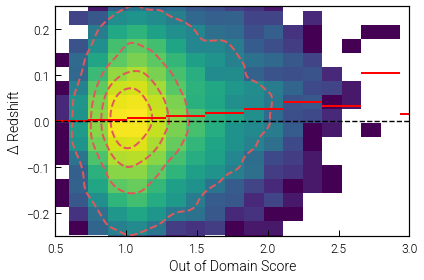

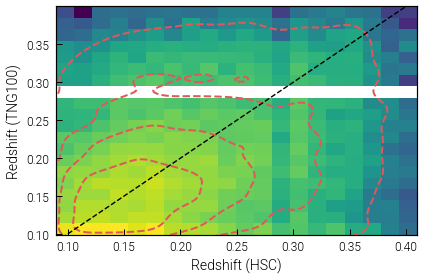

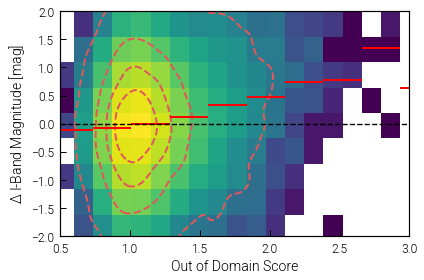

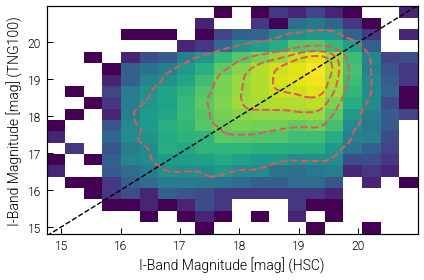

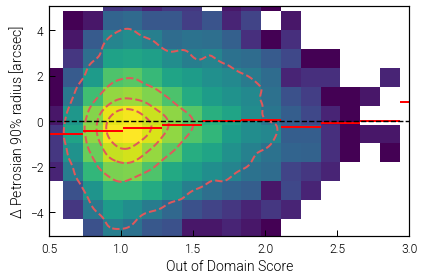

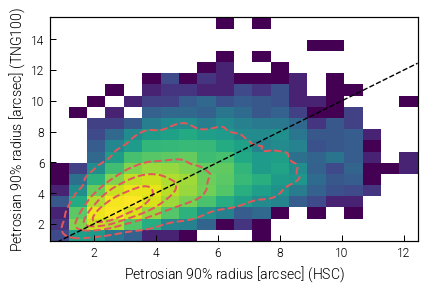

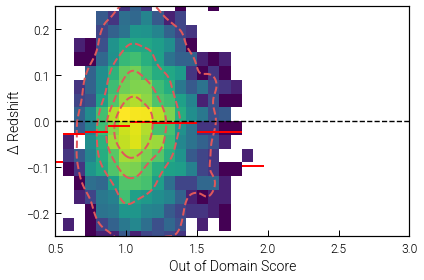

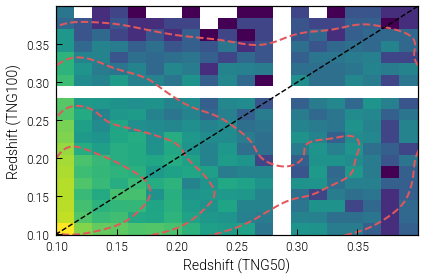

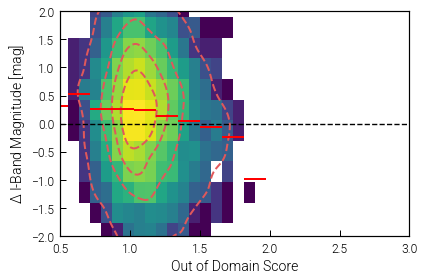

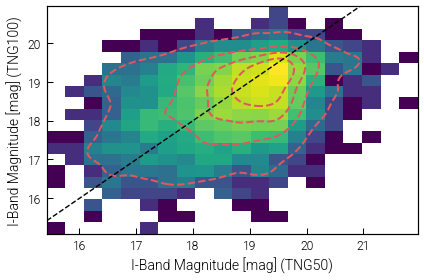

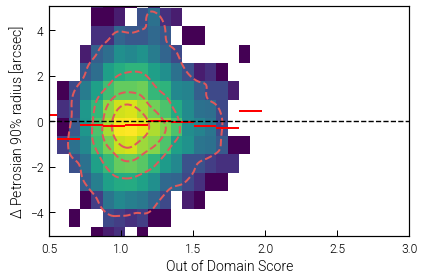

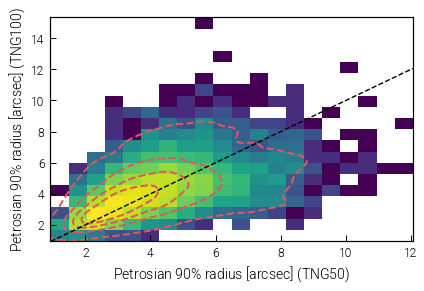

In [14]:
HSC_labels = ['photoz', 'i_cmodel_mag_ge', 'petro_90_light'] 
TNG_labels = ['z', 'i_band_mag_dust_apparent', 'petro_90_light']
labels_human = ['Redshift', 'I-Band Magnitude [mag]', 'Petrosian $90 \%$ radius [arcsec]']
y_limits = [0.25, 2, 30*HSC_arcsec_per_pixel]
x_limits = [0.5, 3.0]


def nn_interpolation(rep, rep_target, df, df_target, label, label_target, dataset, dataset_target):
    mnnd = dt.MeanNormalizedNeighborDistance(rep, n_neighbor=8, p=1)
    score = mnnd.get_normalized_neighbor_distances(rep_target)

    tree = cKDTree(rep_target, compact_nodes=False, balanced_tree=False)
    distance, indexes = tree.query(rep, k=[1], p=1)
    indexes = indexes[:,0]

    for hl, tl, lh, lim in zip(label_target, label, labels_human, y_limits):

        diff = df_target.iloc[indexes][hl].to_numpy() - df[tl].to_numpy()
        plt.hist2d(score, diff, norm=mpl.colors.LogNorm(), bins=20, cmin=2)
        sns.kdeplot(x=score, y=diff, levels=5, linewidths=2, linestyles='dashed')

        bin_statistic, bin_edges, binnumber = stats.binned_statistic(score, diff, statistic='mean', bins=10)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2

        plt.hlines(bin_statistic, bin_edges[:-1], bin_edges[1:], colors='r', lw=2)
        plt.plot(x_limits,[0, 0], 'k--')
        plt.xlabel('Out of Domain Score', fontdict={'fontsize': 14})
        plt.ylabel('$\Delta$ ' + lh, fontdict={'fontsize': 14})
        plt.ylim(-lim, lim)
        plt.xlim(x_limits)
        plt.savefig(f'./temp/nninterpolation_{dataset}_{dataset_target}_{hl}.pdf')
        plt.show()

        plt.hist2d(df_target.iloc[indexes][hl].to_numpy(), df[tl].to_numpy(), norm=mpl.colors.LogNorm(), bins=20)
        sns.kdeplot(x=df_target.iloc[indexes][hl].to_numpy(), y=df[tl].to_numpy(), levels=5, linewidths=2, linestyles='dashed')
        min_h = np.min(df_target.iloc[indexes][hl].to_numpy())
        max_h = np.max(df_target.iloc[indexes][hl].to_numpy())
        plt.plot([min_h, max_h],[min_h, max_h], 'k--')
        plt.xlabel(lh + f' ({dataset_target})', fontdict={'fontsize': 14})
        plt.ylabel(lh + f' ({dataset})', fontdict={'fontsize': 14})
        plt.savefig(f'./temp/nninterpolationerror_{dataset}_{dataset_target}_{hl}.pdf')
        plt.show()
        
nn_interpolation(rep_TNG100_HSC, rep_HSC_TNG100, df_TNG100_HSC, df_HSC_TNG100, TNG_labels, HSC_labels, 'TNG100', 'HSC') 
nn_interpolation(rep_TNG100_TNG50, rep_TNG50_TNG100, df_TNG100_TNG50, df_TNG50_TNG100, TNG_labels, TNG_labels, 'TNG100', 'TNG50')

4it [00:00, 17.89it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_074-250067_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_088-95494_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_091-534119_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_091-326095_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_077-381682_v3_HSC_GRIZY.fits'


8it [00:00, 12.15it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_089-132879_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_083-475934_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_085-391878_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_074-407607_v3_HSC_GRIZY.fits'


12it [00:00, 15.50it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_085-514398_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_087-476861_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_088-396191_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_086-295740_v3_HSC_GRIZY.fits'


16it [00:01, 17.40it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_086-470495_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_075-66182_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_077-276967_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_078-201377_v0_HSC_GRIZY.fits'


20it [00:01, 18.27it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_085-454898_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_079-147075_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_080-447072_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_073-255328_v2_HSC_GRIZY.fits'


/tmp/ipykernel_141053/1082717278.py:133: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, self.NUM_COUNTERPARTS+1)
22it [00:01, 18.46it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_087-478843_v0_HSC_GRIZY.fits'


26it [00:01, 14.50it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_087-536821_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_085-477040_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_088-506350_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_081-456190_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_076-283988_v3_HSC_GRIZY.fits'


30it [00:01, 16.56it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_080-417519_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_087-132753_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_081-448256_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_089-549471_v3_HSC_GRIZY.fits'


34it [00:02, 17.80it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_090-273977_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_078-35386_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_072-279404_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_085-392252_v0_HSC_GRIZY.fits'


38it [00:02, 18.33it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_088-357831_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_088-454444_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_090-464982_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_081-355161_v0_HSC_GRIZY.fits'


42it [00:02, 18.73it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_082-12260_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_089-516483_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_084-498445_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_080-289061_v2_HSC_GRIZY.fits'


46it [00:02, 13.47it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_084-283304_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_086-496807_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_090-511321_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_089-481935_v2_HSC_GRIZY.fits'


50it [00:03, 14.78it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_079-169468_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_087-518416_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_090-516862_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_082-449601_v1_HSC_GRIZY.fits'


54it [00:03, 16.38it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_072-324741_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_083-442713_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_084-347298_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_080-478638_v3_HSC_GRIZY.fits'


58it [00:03, 17.68it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_074-397180_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_083-59404_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_078-243692_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_083-112707_v3_HSC_GRIZY.fits'


62it [00:03, 17.96it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_090-261279_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_078-375430_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_083-346043_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_090-223669_v0_HSC_GRIZY.fits'


66it [00:04, 18.54it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_086-25636_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_091-534453_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_087-477677_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_086-97322_v3_HSC_GRIZY.fits'


68it [00:04, 18.55it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_081-281083_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_090-52905_v1_HSC_GRIZY.fits'


72it [00:04, 12.09it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_087-519677_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_083-503286_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_078-375336_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_082-419750_v3_HSC_GRIZY.fits'


76it [00:04, 14.88it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_091-118062_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_087-480087_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_084-396260_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_082-417204_v1_HSC_GRIZY.fits'


80it [00:05, 16.65it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_077-1_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_089-472441_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_087-224087_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_086-480586_v0_HSC_GRIZY.fits'


84it [00:05, 17.82it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_084-373216_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_086-491954_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_090-193709_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_090-452288_v2_HSC_GRIZY.fits'


88it [00:05, 18.46it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_079-441574_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_090-514404_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_075-166609_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_088-294943_v3_HSC_GRIZY.fits'


92it [00:05, 18.80it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_083-403385_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_085-282265_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_089-484572_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_088-530641_v0_HSC_GRIZY.fits'


96it [00:05, 18.99it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_087-296558_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_082-462479_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_083-424292_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_077-430957_v0_HSC_GRIZY.fits'


100it [00:06, 16.25it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_088-290582_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_088-507989_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG100/images/shalo_080-387872_v3_HSC_GRIZY.fits'



0it [00:00, ?it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_087-616723_v1_HSC_GRIZY.fits'


4it [00:00,  6.07it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-69035_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-643806_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-493930_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_086-601355_v2_HSC_GRIZY.fits'


8it [00:00, 10.92it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_085-446247_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_087-539951_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-494791_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_077-440286_v1_HSC_GRIZY.fits'


12it [00:01, 14.01it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-422709_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_088-622851_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_083-470543_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_084-354029_v1_HSC_GRIZY.fits'


16it [00:01, 16.10it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_087-110970_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-649121_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_075-213030_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_086-451948_v1_HSC_GRIZY.fits'


20it [00:01, 17.55it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_086-723513_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-69049_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-498275_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_081-492716_v3_HSC_GRIZY.fits'


24it [00:01, 18.35it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_074-256619_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_086-91122_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_088-205593_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_085-546309_v1_HSC_GRIZY.fits'


28it [00:02, 18.76it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_072-405362_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_073-264457_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_080-339321_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-525526_v2_HSC_GRIZY.fits'


32it [00:02, 18.82it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-552790_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-546599_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_084-346140_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_081-478093_v3_HSC_GRIZY.fits'


36it [00:02, 18.97it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_087-247616_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_086-408721_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_075-400935_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-140990_v1_HSC_GRIZY.fits'


40it [00:02, 19.05it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_074-377415_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_087-480627_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-41_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_072-77346_v1_HSC_GRIZY.fits'


44it [00:03,  9.51it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-553217_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_083-387566_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_088-611769_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_072-429055_v0_HSC_GRIZY.fits'


48it [00:03, 12.78it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_088-445160_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_083-11_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_086-136848_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-623783_v3_HSC_GRIZY.fits'


52it [00:03, 15.38it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-495422_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-614484_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_086-562501_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-624175_v0_HSC_GRIZY.fits'


56it [00:04, 16.93it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_087-555640_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_088-65783_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_086-496082_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_081-355861_v3_HSC_GRIZY.fits'


60it [00:04, 17.97it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-548485_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-118201_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_088-553588_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-658270_v2_HSC_GRIZY.fits'


64it [00:04, 18.53it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-452357_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_088-616977_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-116872_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_087-605076_v2_HSC_GRIZY.fits'


68it [00:04, 18.83it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_086-555992_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-636188_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_078-277676_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_082-411164_v3_HSC_GRIZY.fits'


72it [00:04, 18.98it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_083-528564_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-342720_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-517172_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_083-214605_v0_HSC_GRIZY.fits'


76it [00:05, 18.98it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-462811_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-526537_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-402142_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-484126_v2_HSC_GRIZY.fits'


80it [00:05, 19.05it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_086-519430_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-549470_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_074-473703_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_079-282257_v2_HSC_GRIZY.fits'


84it [00:05, 19.10it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-608917_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-531201_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-551012_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-521947_v1_HSC_GRIZY.fits'


88it [00:05, 19.13it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-486963_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_083-526378_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_090-619176_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-658316_v3_HSC_GRIZY.fits'


92it [00:05, 18.98it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_087-589717_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_088-560151_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_077-481459_v0_HSC_GRIZY.fits'


96it [00:06,  8.21it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_078-295734_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-618527_v0_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-354683_v3_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-580251_v2_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_089-422235_v2_HSC_GRIZY.fits'


100it [00:06, 14.30it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-579766_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_083-469531_v1_HSC_GRIZY.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC_TNG50/images/shalo_091-643304_v3_HSC_GRIZY.fits'



4it [00:00, 19.03it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43220165705339126.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41126837299989017.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/70417672445133550.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42811426552692278.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41139889705609760.fits'


8it [00:00, 18.66it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/39904596981712323.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41122580987402679.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41007828051188649.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40642794485728231.fits'


12it [00:00, 18.83it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41060471465336343.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41570348507883004.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42714673824423790.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40620379051410023.fits'


16it [00:00, 19.03it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42243928228908263.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42146767478743244.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42248206016340342.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41596887110801525.fits'


20it [00:01, 19.12it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44345782144354645.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40633568895984210.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41025407352331402.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42652809115490992.fits'


24it [00:01, 18.67it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44768282372235584.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43141404595084127.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/38548894849719640.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43119422952467783.fits'


28it [00:01, 18.73it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41649792517954890.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41029526225964777.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44235715017464544.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44179343571699662.fits'


32it [00:01, 18.92it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41610910179029000.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/37489661425246244.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/45850326368017273.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41148960676518274.fits'


36it [00:01, 19.03it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41205989252298754.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40128493626876473.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42076811051426257.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/45837003379459209.fits'


40it [00:02, 19.07it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/39904450952835320.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42204225551230354.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42767433202685215.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42252728616899360.fits'


44it [00:02, 19.09it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40964234133130287.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41113501426547144.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40031581984800090.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42279275809756317.fits'


48it [00:02, 19.02it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42155443312675801.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41188006224220075.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40642781600830910.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40999147922282280.fits'


52it [00:02, 19.06it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44187478239759975.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43194181153215124.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42036691761909826.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/45278185184574196.fits'


54it [00:02, 19.04it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/46883734154141617.fits'


58it [00:03,  6.81it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42041484945413880.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42173976096563778.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41149115295358998.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41241332538176136.fits'


62it [00:04, 10.13it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40629995483190628.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43105829380972612.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43202015173565178.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41575712922033320.fits'


66it [00:04, 13.23it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42041068333583960.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40005060561744496.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/36416666925549624.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/45375079646774324.fits'


70it [00:04, 15.45it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43699557070041228.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41750797263858546.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42142253468113973.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40968224157744562.fits'


74it [00:04, 17.12it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40664896387435521.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44280502936428044.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/69612563645622810.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42252050012063856.fits'


78it [00:05, 18.08it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42674666204058534.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41161321592409623.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42155984478556088.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41764846101873279.fits'


82it [00:05, 18.16it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/36425746486409590.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41737628894119297.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42200368670596829.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/37480324166341015.fits'


86it [00:05, 18.20it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42186337012443495.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/70387169587389723.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41711240615056565.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42639073810082696.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43752466772162651.fits'


90it [00:05, 18.64it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41086713715506430.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42735968272270798.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43162840776864328.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41667247265046947.fits'


94it [00:05, 18.91it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41676597408844626.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41711515492960966.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41127262501756155.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41223607208140153.fits'


98it [00:06, 19.06it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41641125273945084.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41671503577631167.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44781596770853986.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41716454705336665.fits'


100it [00:06, 16.14it/s]


[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41716574964435660.fits'


4it [00:00, 19.28it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44794254039469566.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42041635269273139.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/37498444633369731.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44222916014927038.fits'


8it [00:00, 19.01it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41671641016587138.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41693772983062828.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44323925055789210.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43246979186184948.fits'


12it [00:00, 19.12it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/37493355097119928.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/36438661453072549.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40097973589261898.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/45836990494557122.fits'


16it [00:00, 19.16it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41596741081912426.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41646073076276151.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/45304294290768356.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42036949459942959.fits'


20it [00:01, 19.18it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42098543585938785.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43158172147405947.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/38545063738888929.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41236522174803845.fits'


24it [00:01, 19.19it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42186766509172365.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44231982690883072.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43097007518140956.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44342079882543136.fits'


28it [00:01, 19.02it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42802501610651985.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43180463027673466.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/70356396146709082.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/46914378745791668.fits'


32it [00:01, 19.08it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41623550267781536.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/36425321284646626.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40057991738708744.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42129866782431579.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42151040971209306.fits'


36it [00:02,  6.19it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41114059772291228.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/39934824961551478.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42182501606645356.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/38558227813651060.fits'


40it [00:03,  9.45it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41601950877237831.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/69586884036160967.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/69564610335760622.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40071044144322785.fits'


44it [00:03, 12.67it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43774182126785856.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41043128387388934.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42089459730092352.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44271715433339273.fits'


48it [00:03, 15.07it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42829023033715041.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/71173724128170283.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42260983544049844.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/45841001994013918.fits'


52it [00:03, 16.92it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/38558382432481122.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41228138398644445.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41126957559082142.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40163677998967271.fits'


56it [00:03, 18.00it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44293022766097954.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40088915503235340.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43748068725643966.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42283106920593017.fits'


60it [00:04, 18.58it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41649521935017507.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41641009309840794.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41104301606573455.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43233785046652471.fits'


64it [00:04, 18.76it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42670122128665002.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40581213244638010.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40067041234794378.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41139473093780128.fits'


68it [00:04, 18.94it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42639889853862678.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/36415984025750274.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/37493930622734831.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/69630589623363721.fits'


72it [00:04, 18.70it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42630402271116290.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/45317900747164981.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40964371572082701.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43237629042382412.fits'


76it [00:05, 18.91it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/39948023396057926.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41131381375374707.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40669290138978038.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41658330912932874.fits'


80it [00:05, 17.62it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41171084053072382.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/40114741141587829.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41021146744766530.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43114475150136461.fits'


84it [00:05, 17.96it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41702856838900310.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41188560275002430.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41750960472618509.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41078450198440022.fits'


88it [00:05, 18.54it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41029955722701382.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43365709262118153.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41755216785202508.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43149238615431968.fits'


92it [00:05, 18.85it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/43153791280765353.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41082989978875118.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44429774524796088.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41016469525393459.fits'


96it [00:06, 18.86it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44768544365241867.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/44249020826150189.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41192524529824116.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/38558773274501272.fits'


100it [00:06, 15.79it/s]

[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41021421622683963.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/41069108644570521.fits'
[Errno 2] No such file or directory: '../../dataset_raw/HSC/images/42054953962858808.fits'


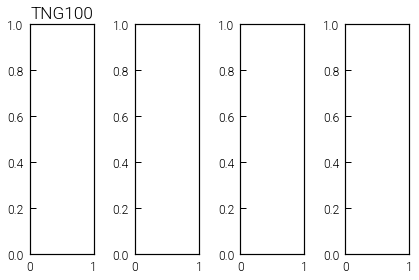

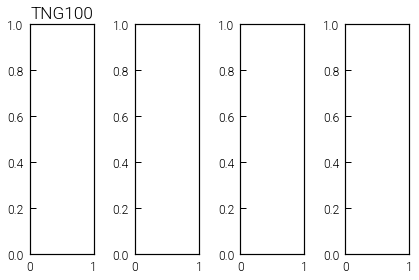

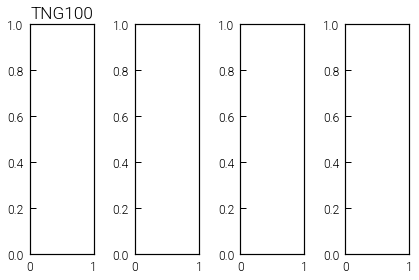

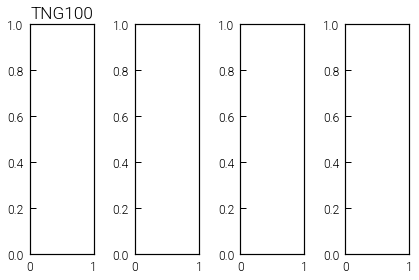

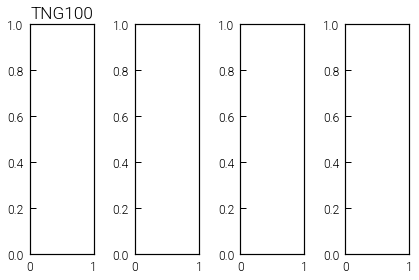

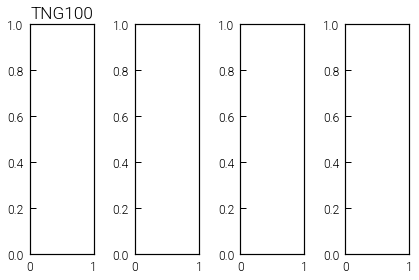

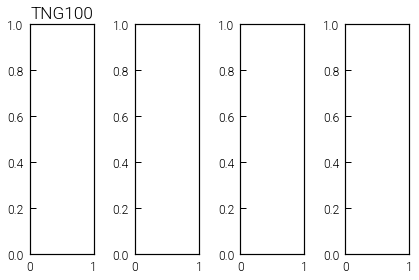

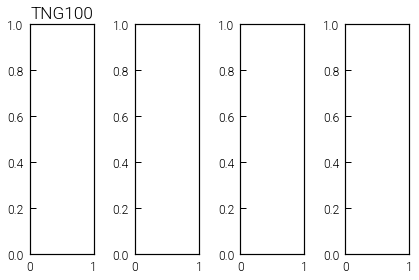

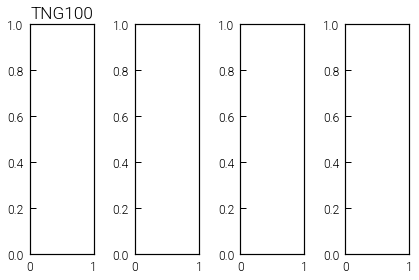

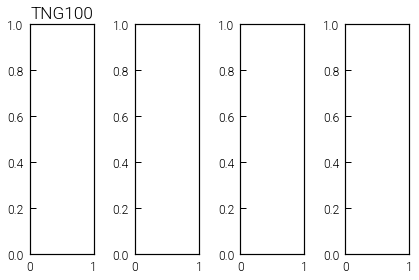

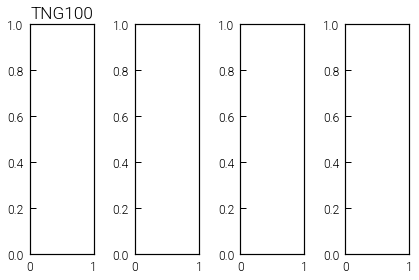

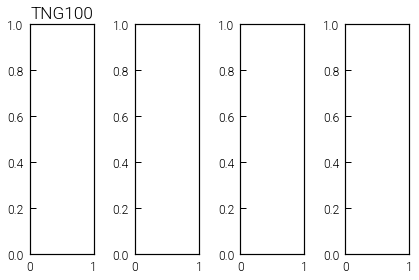

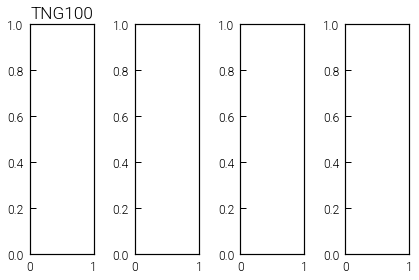

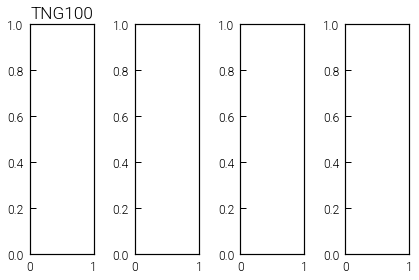

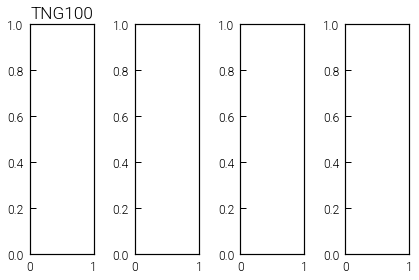

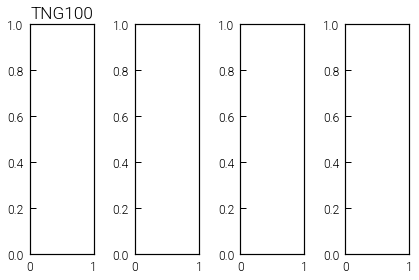

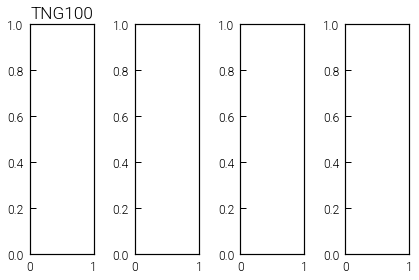

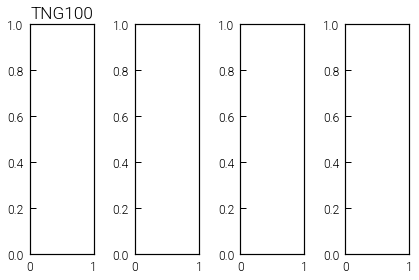

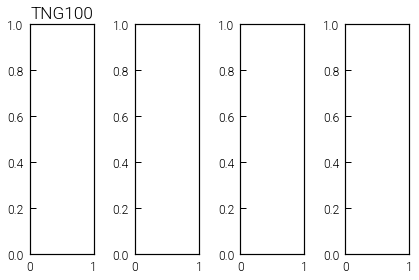

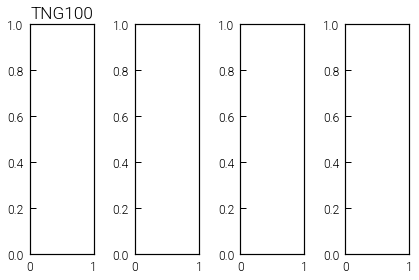

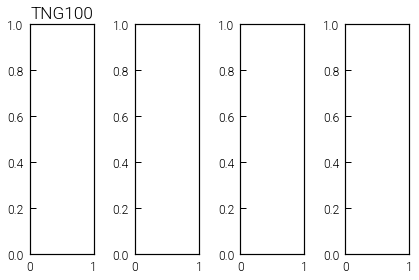

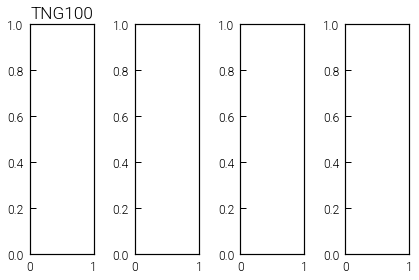

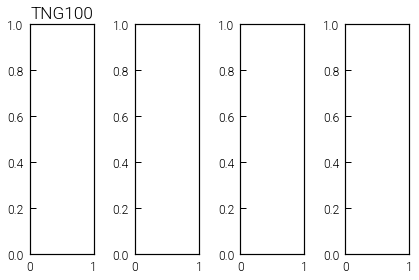

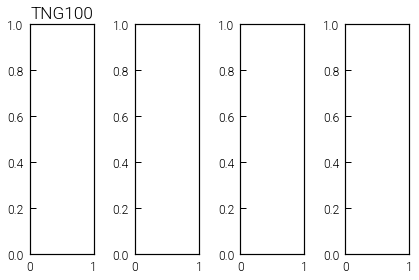

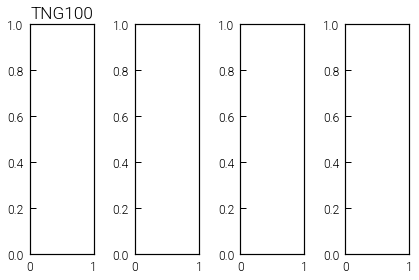

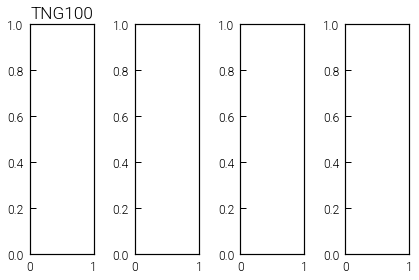

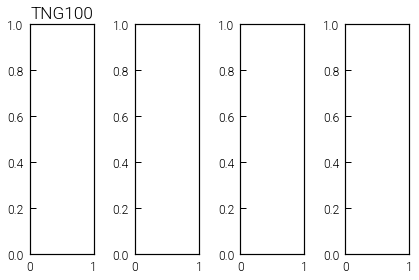

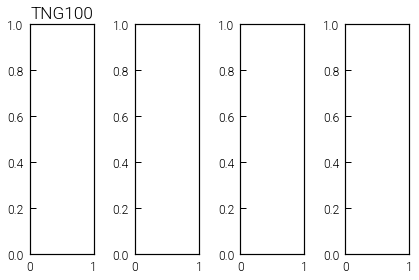

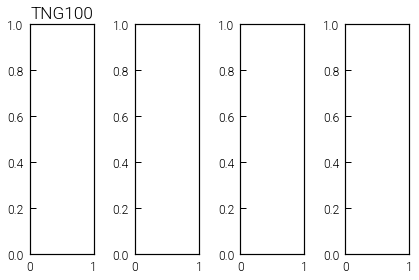

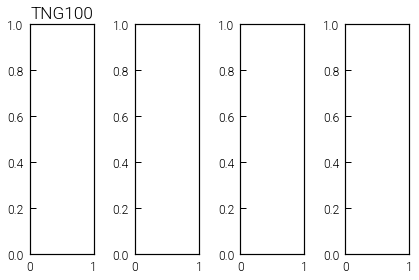

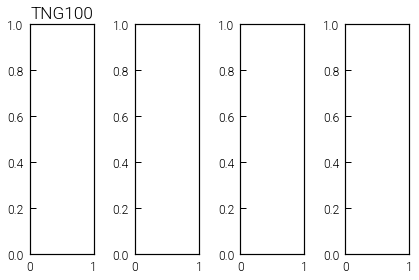

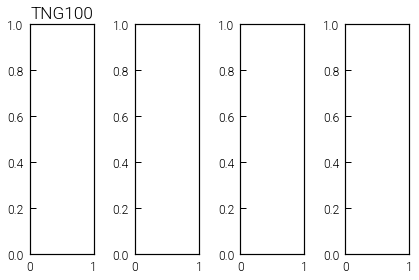

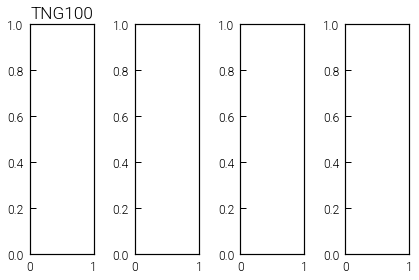

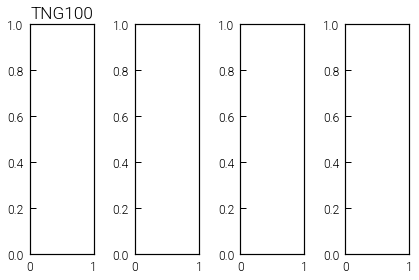

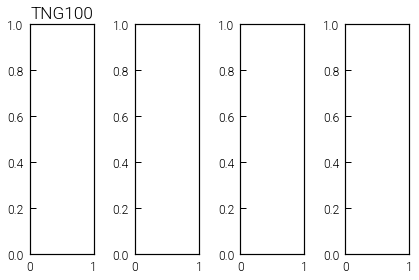

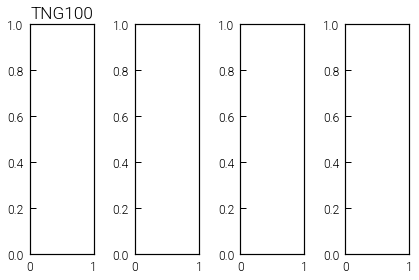

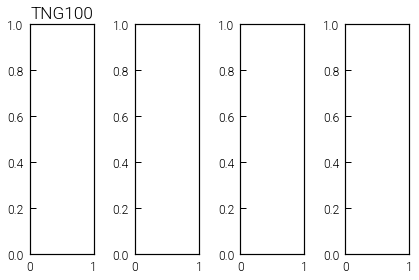

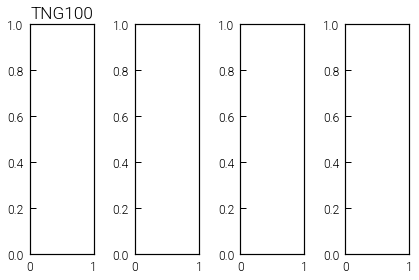

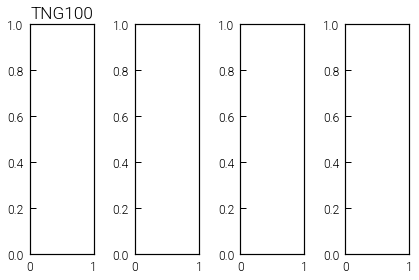

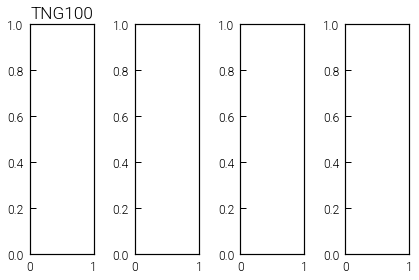

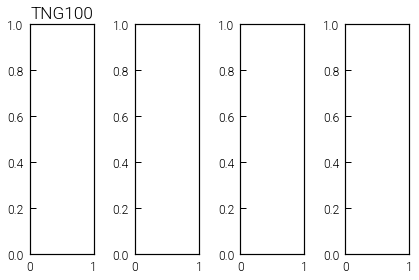

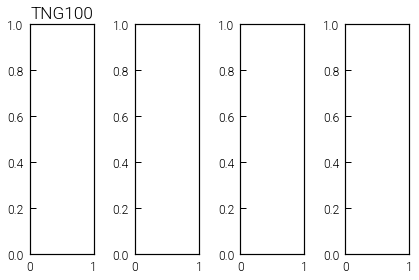

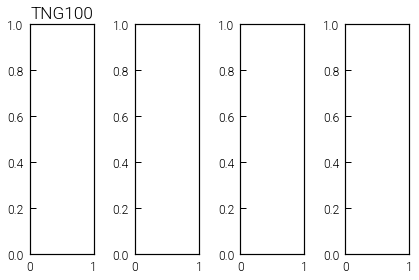

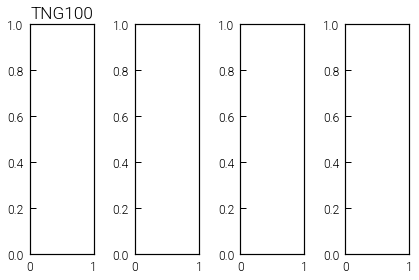

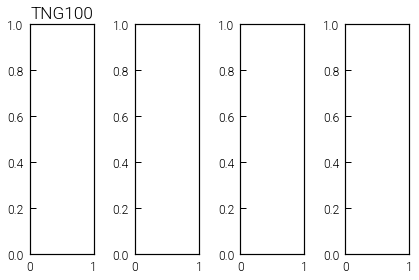

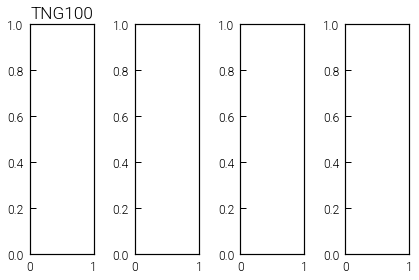

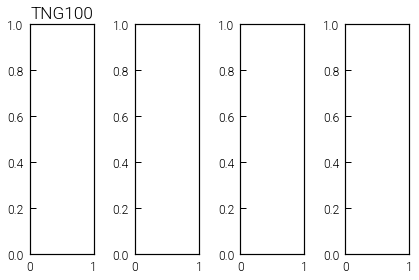

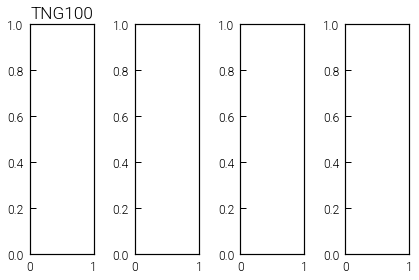

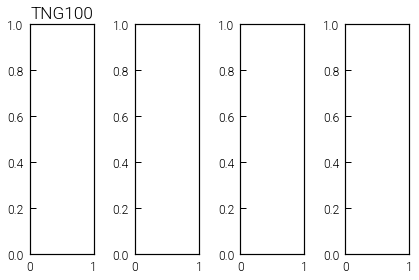

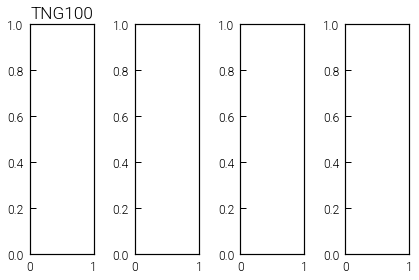

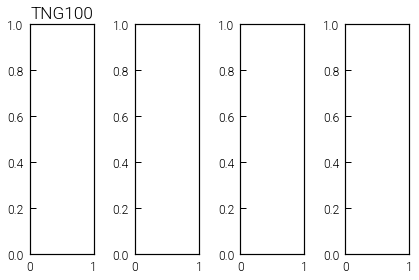

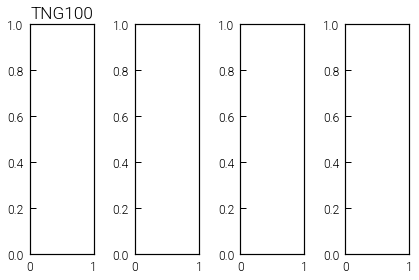

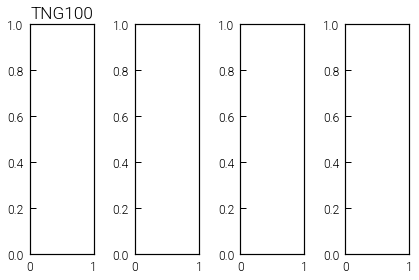

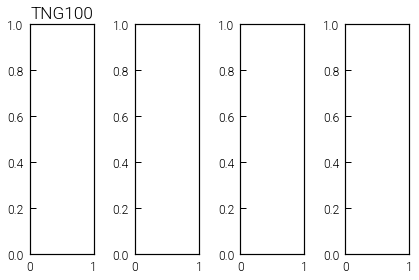

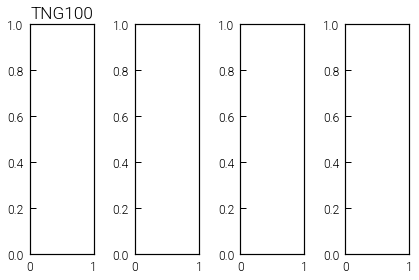

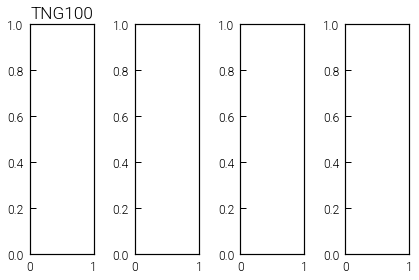

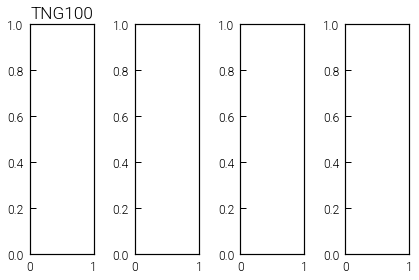

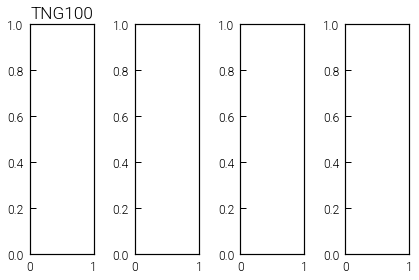

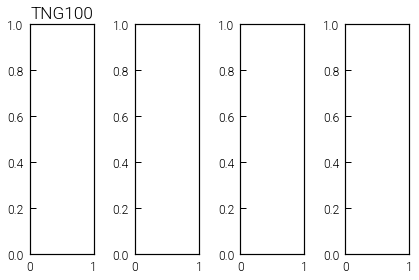

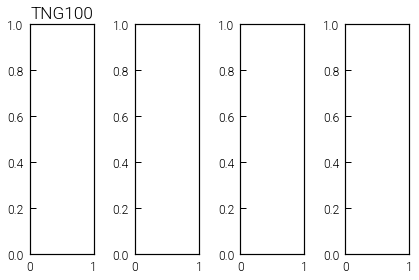

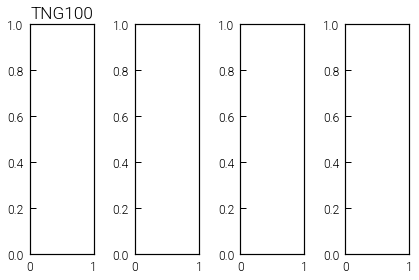

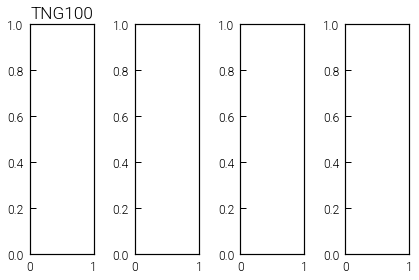

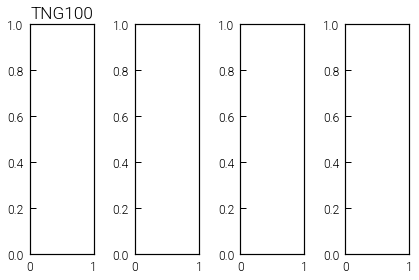

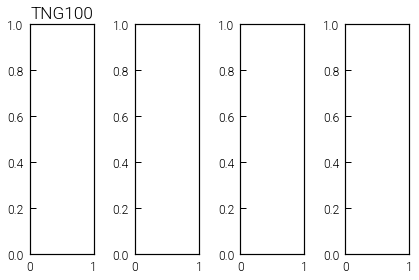

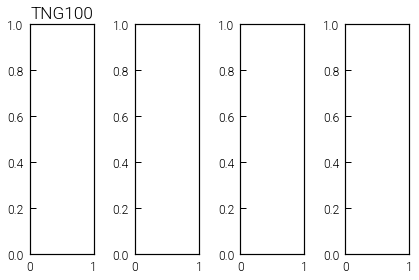

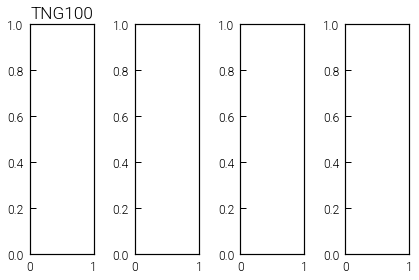

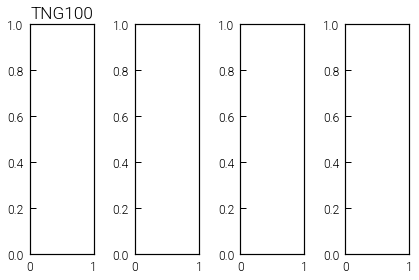

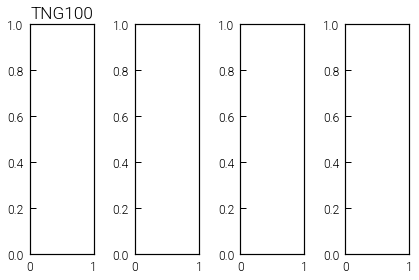

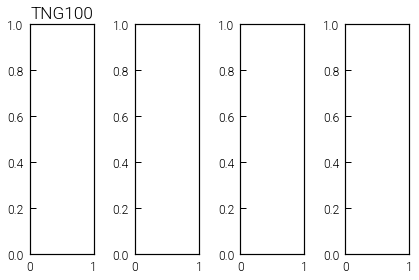

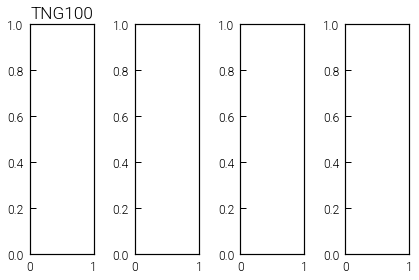

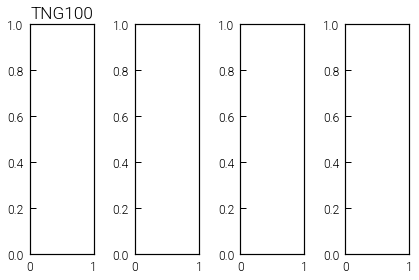

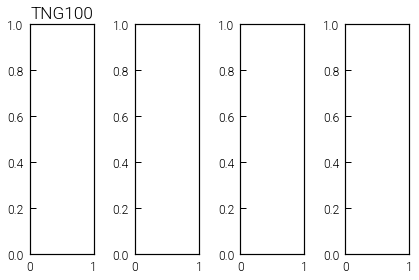

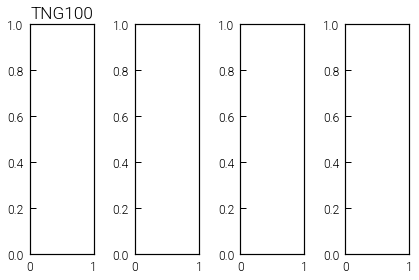

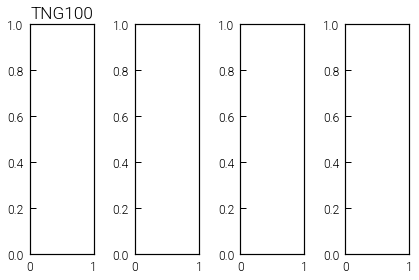

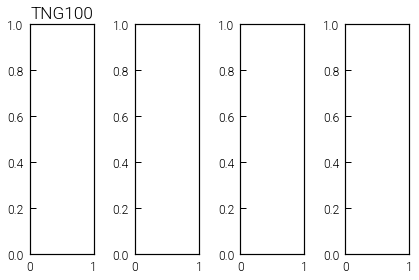

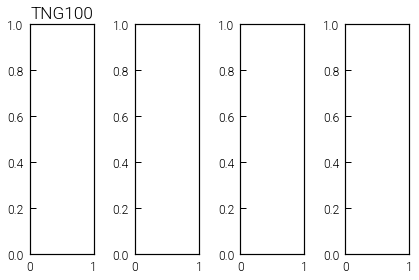

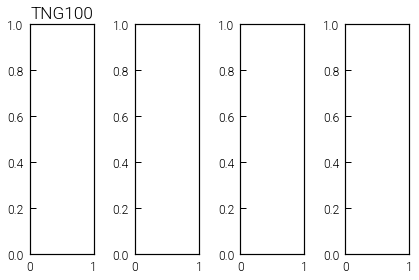

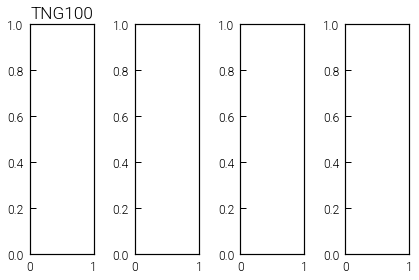

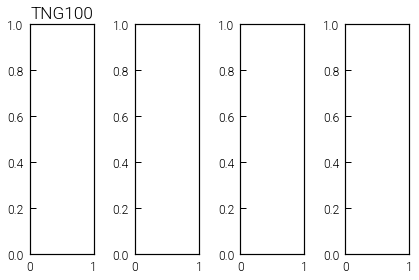

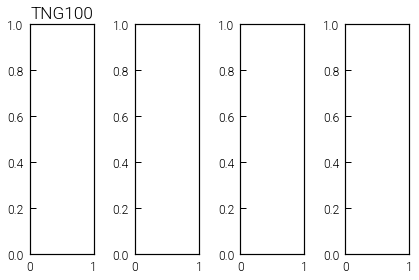

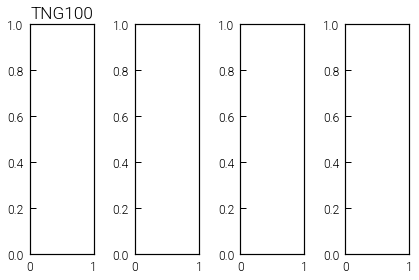

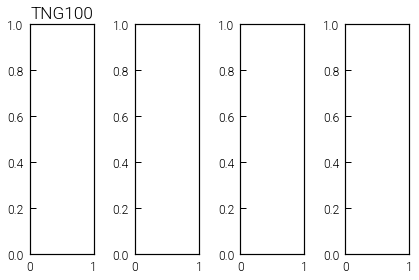

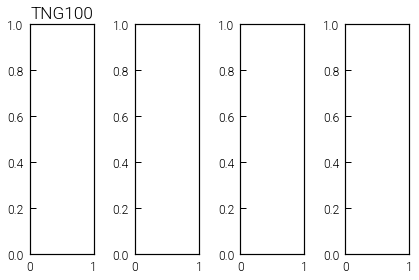

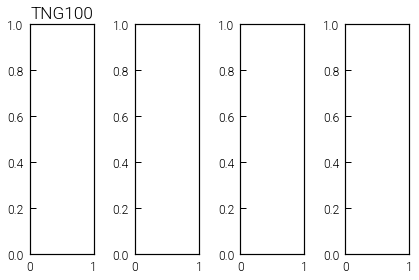

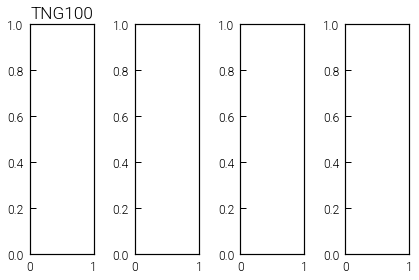

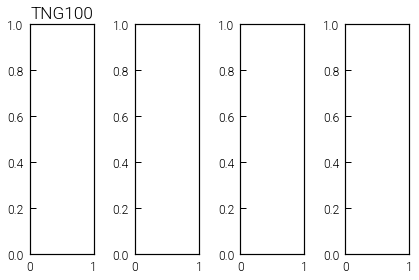

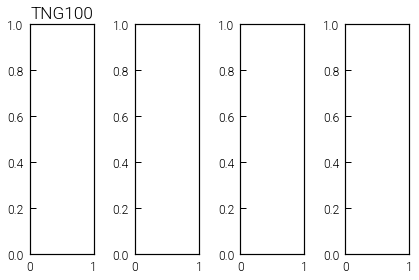

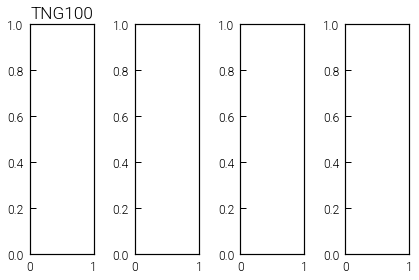

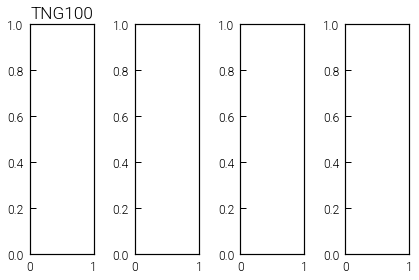

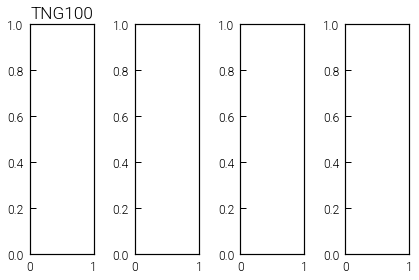

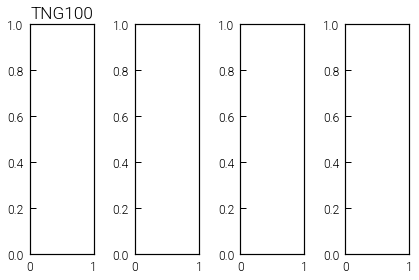

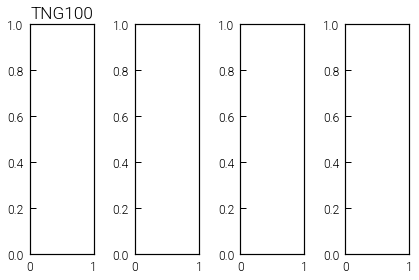

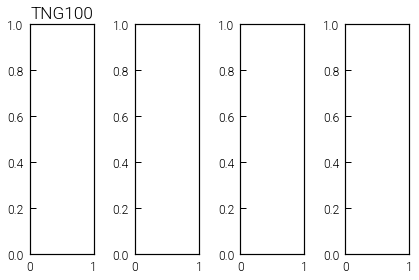

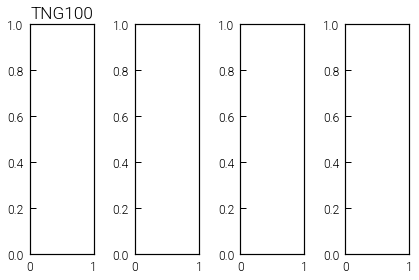

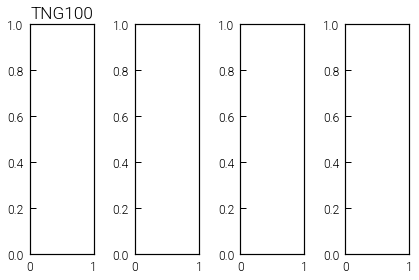

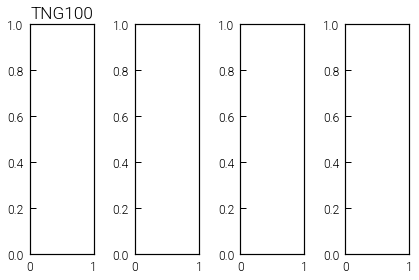

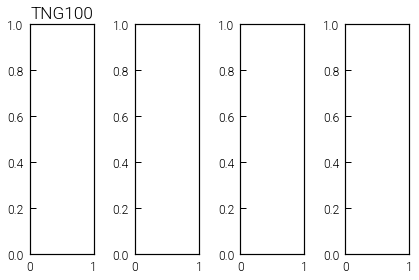

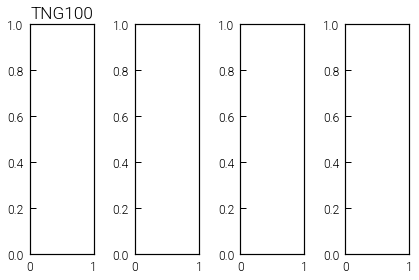

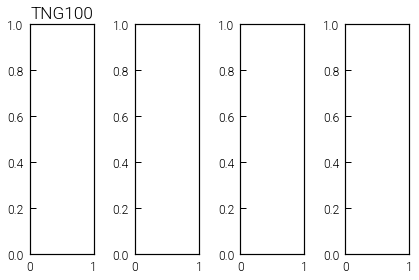

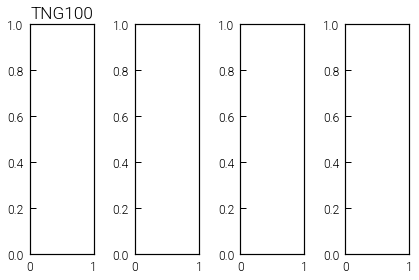

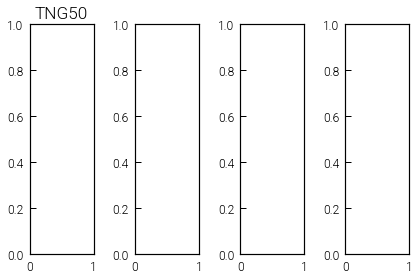

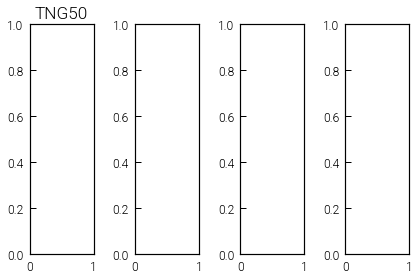

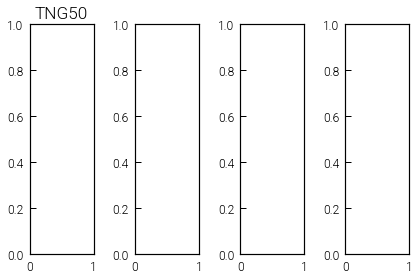

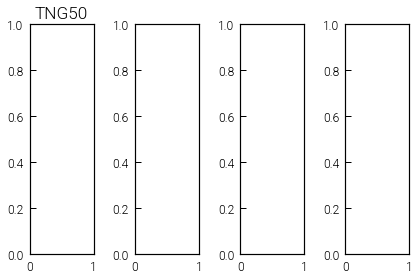

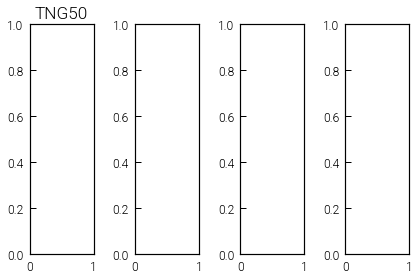

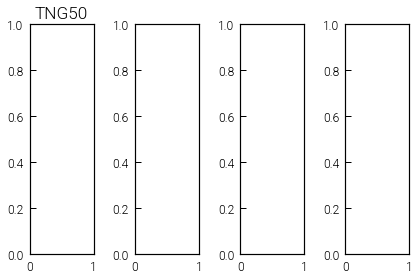

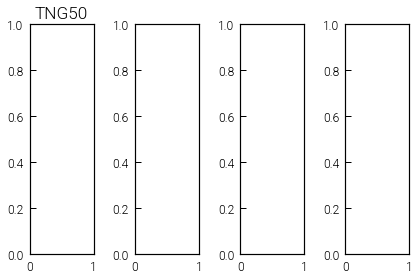

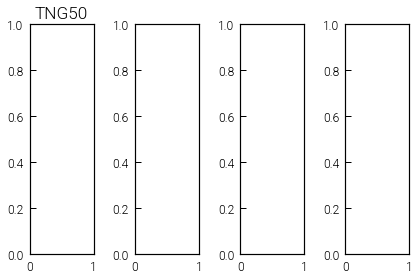

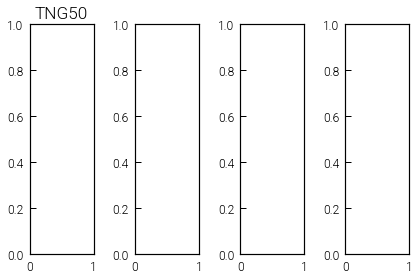

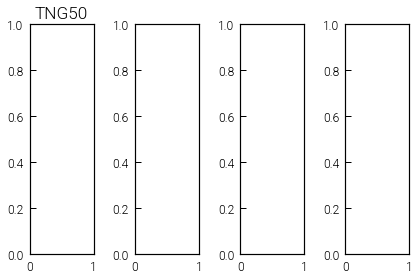

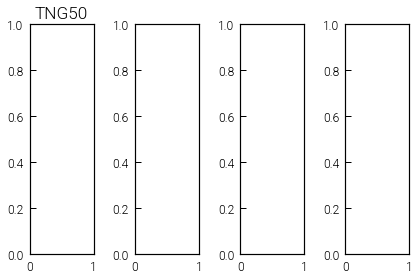

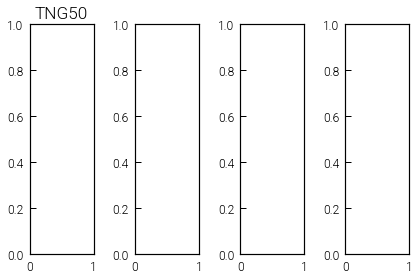

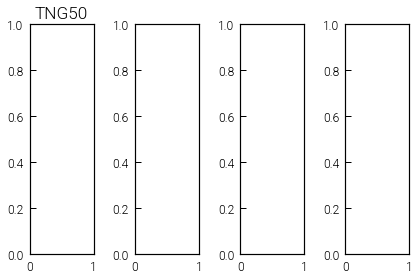

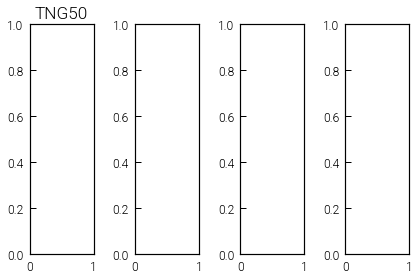

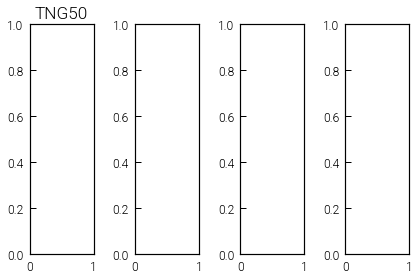

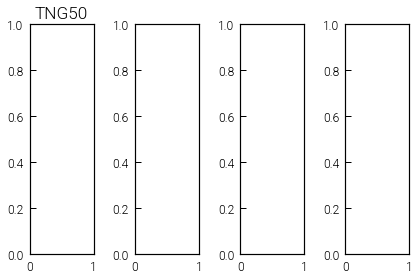

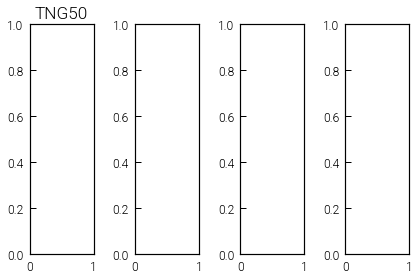

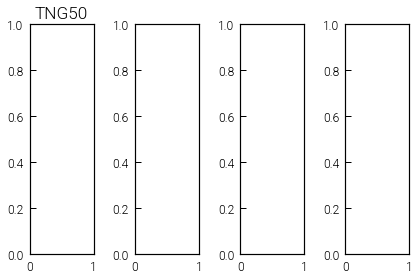

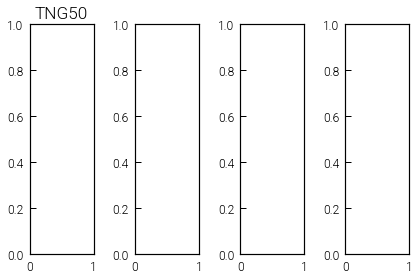

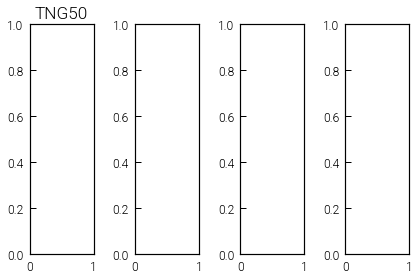

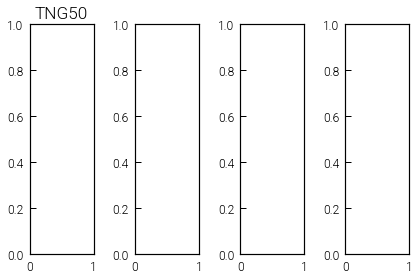

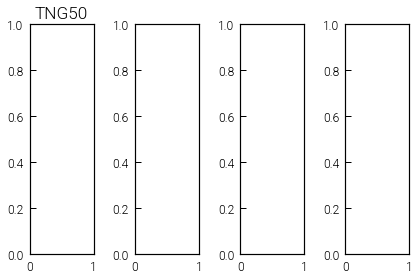

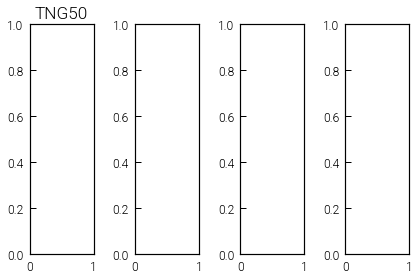

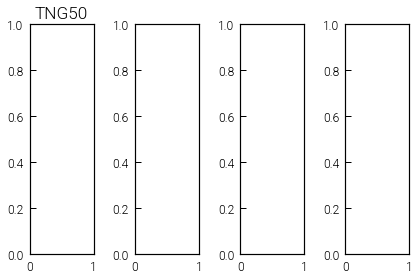

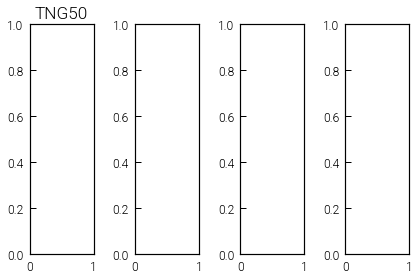

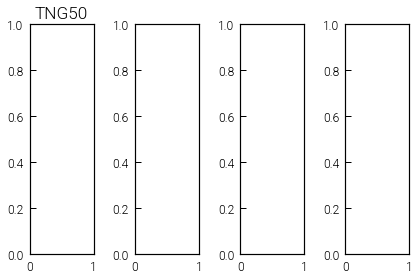

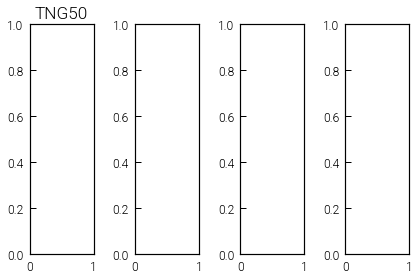

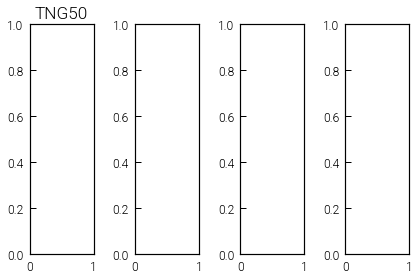

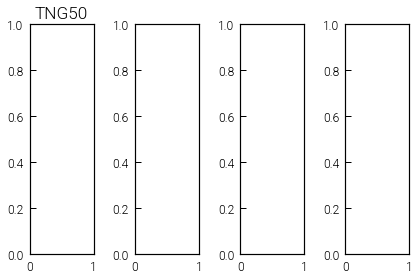

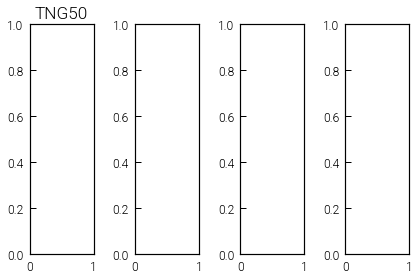

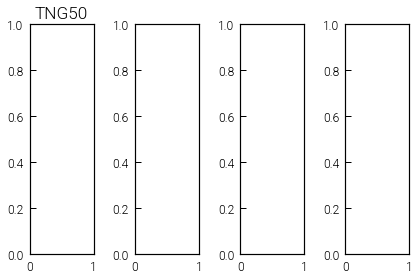

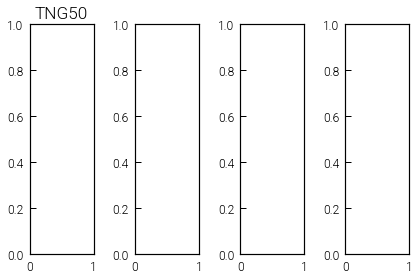

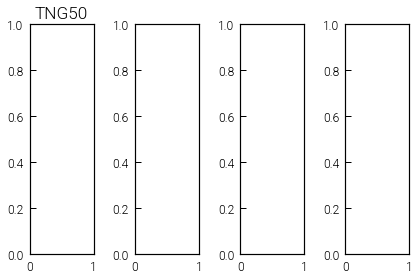

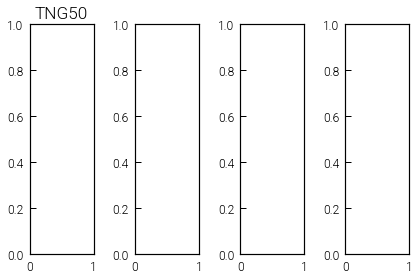

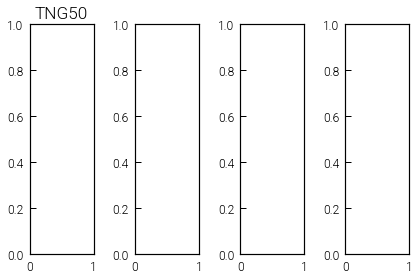

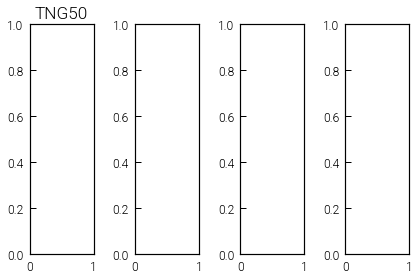

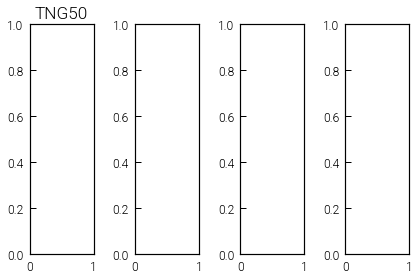

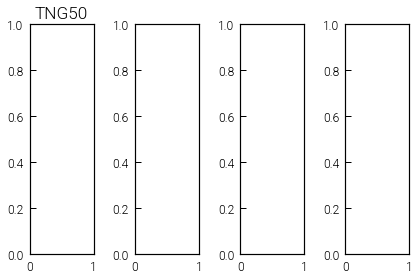

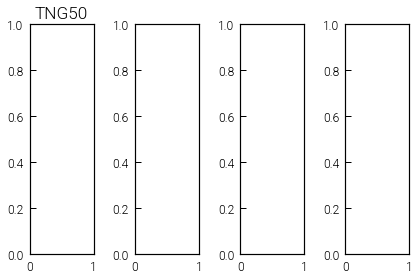

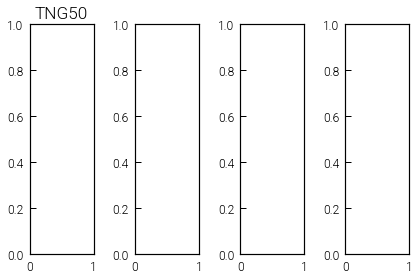

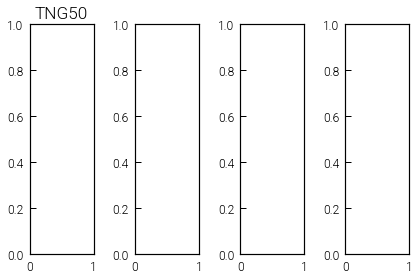

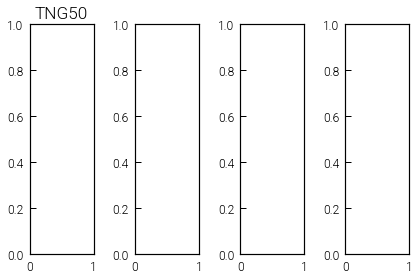

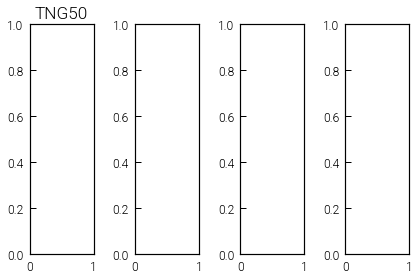

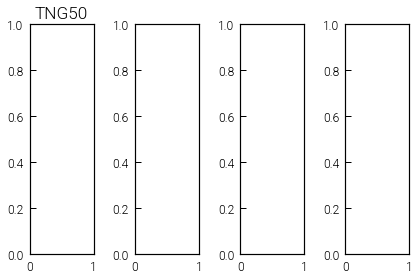

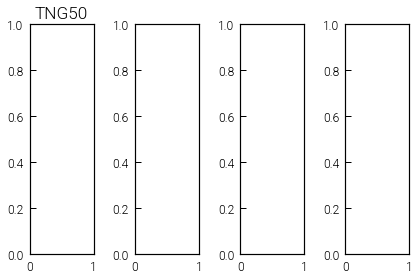

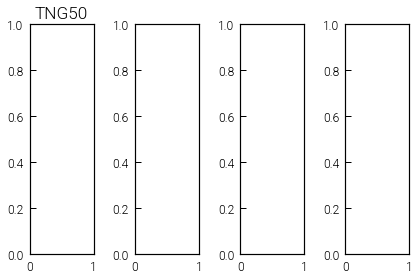

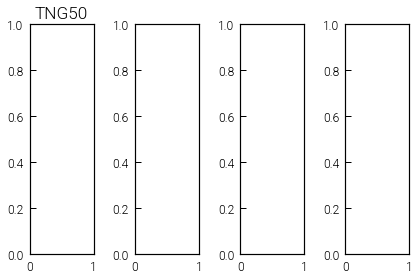

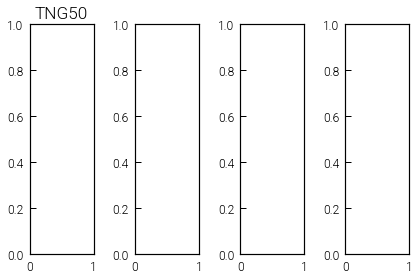

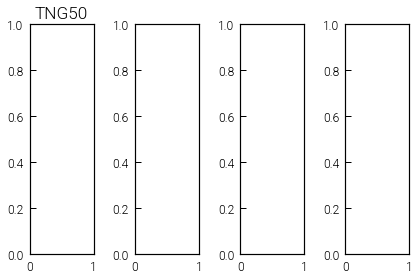

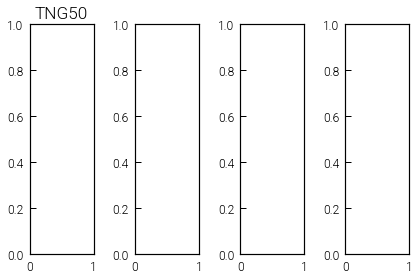

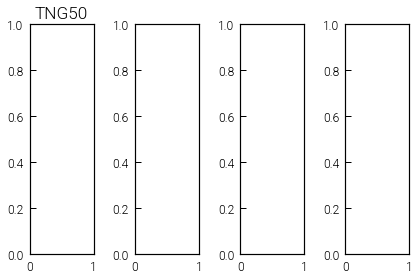

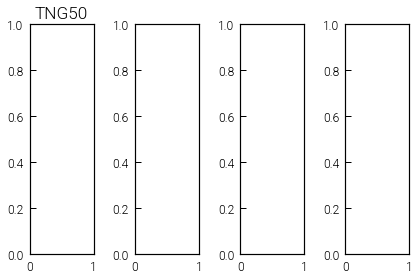

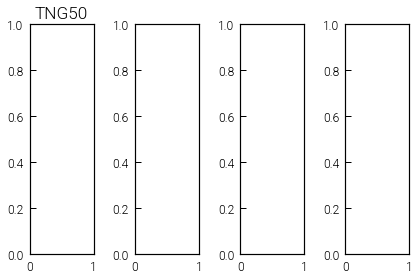

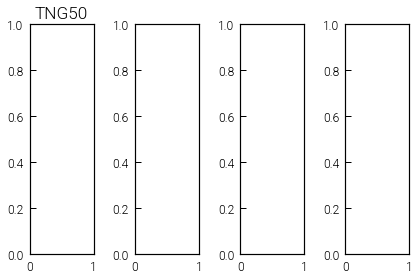

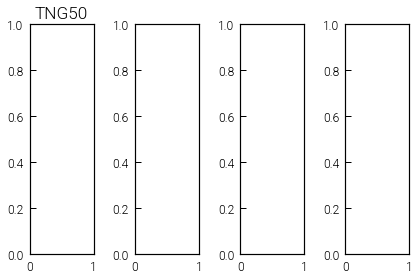

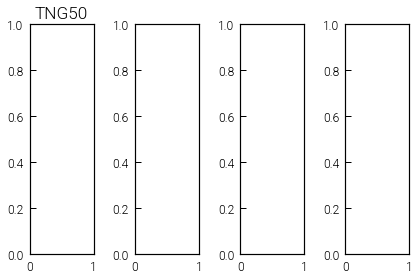

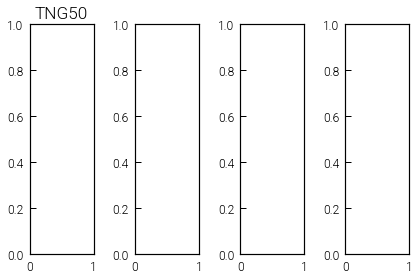

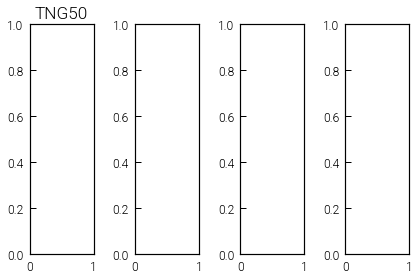

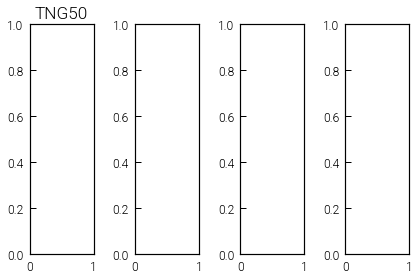

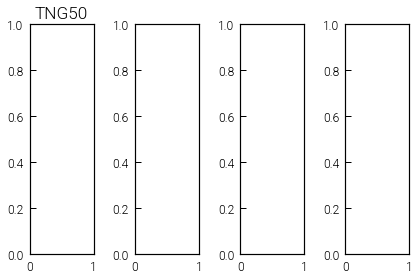

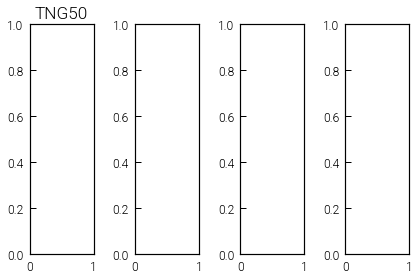

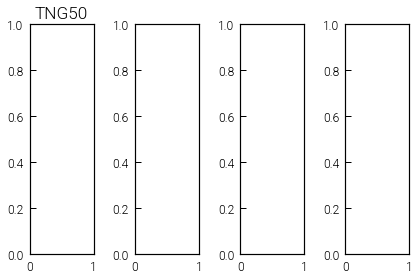

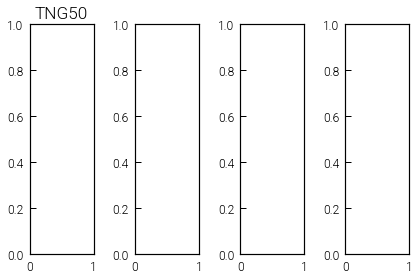

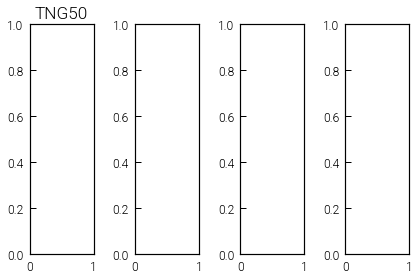

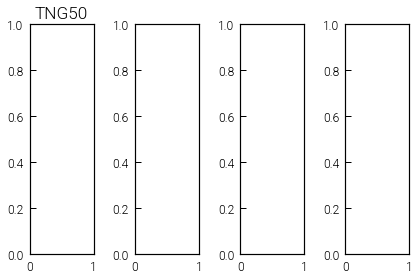

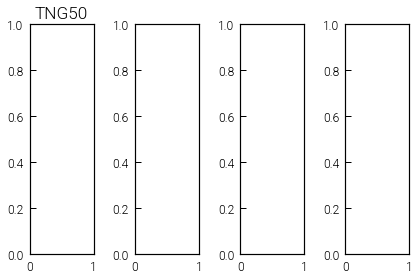

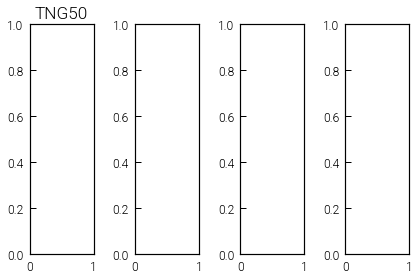

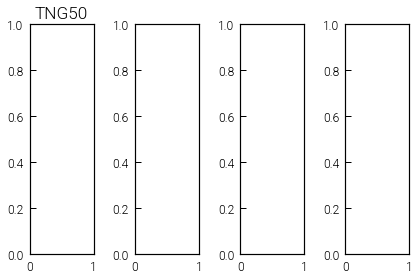

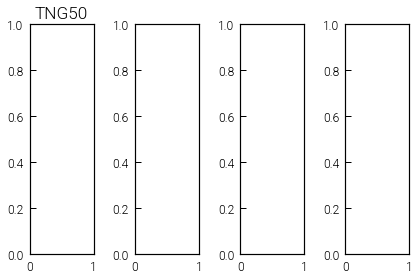

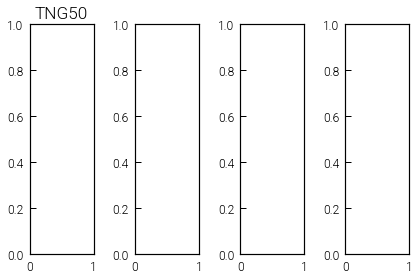

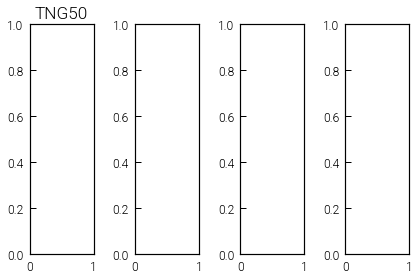

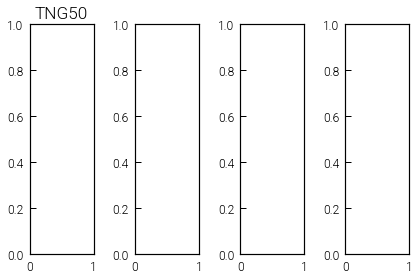

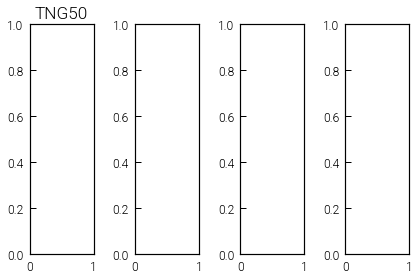

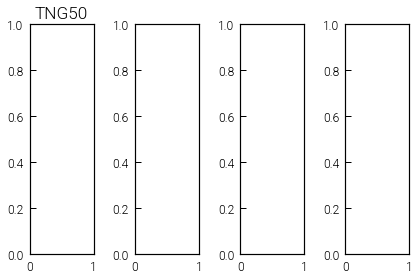

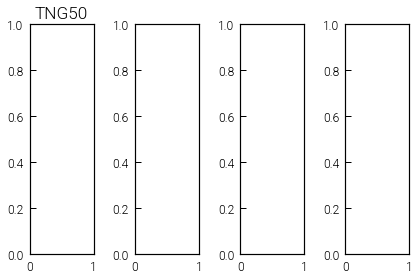

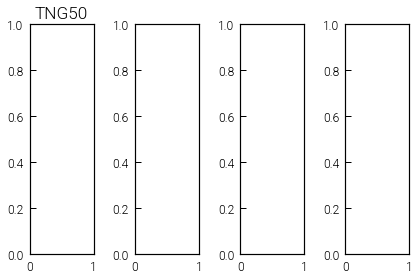

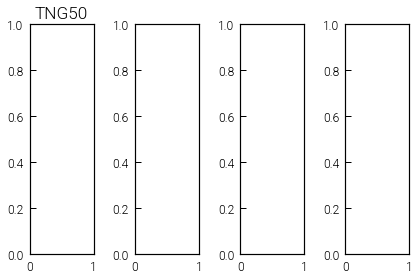

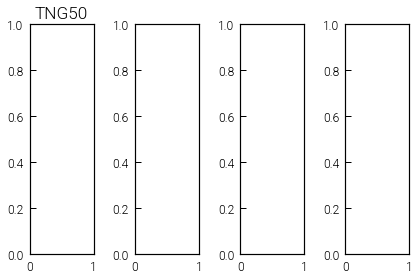

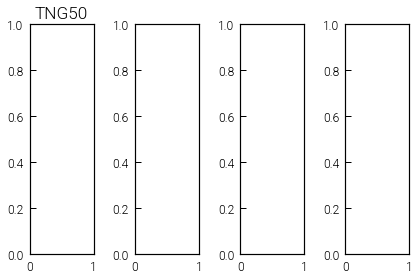

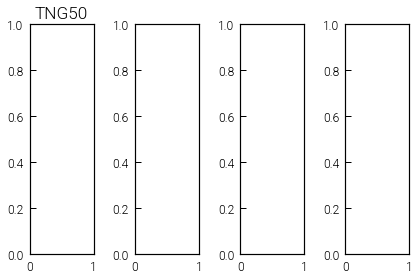

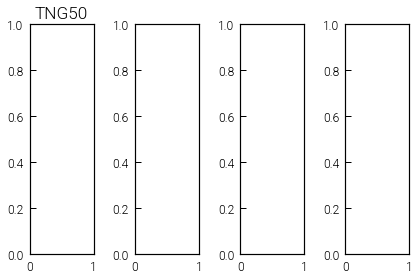

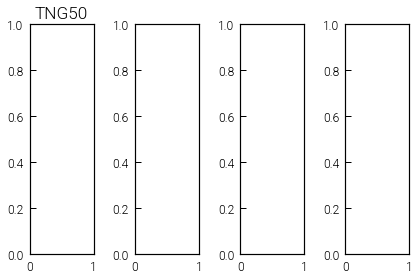

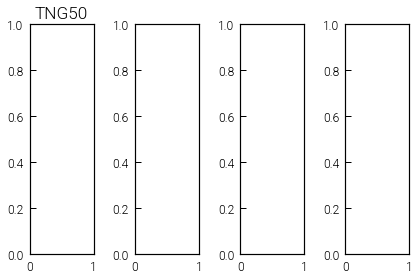

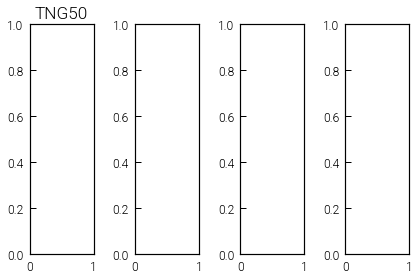

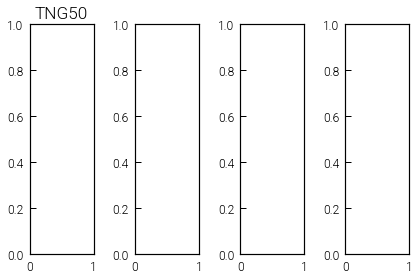

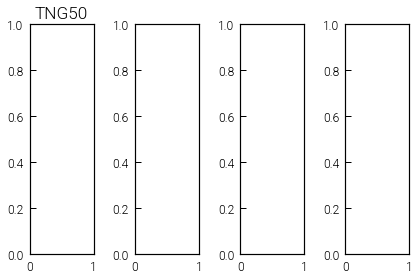

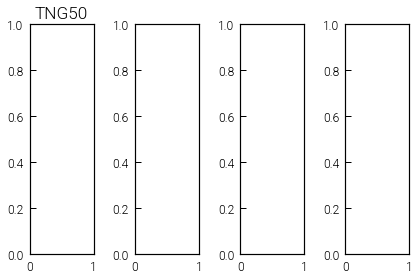

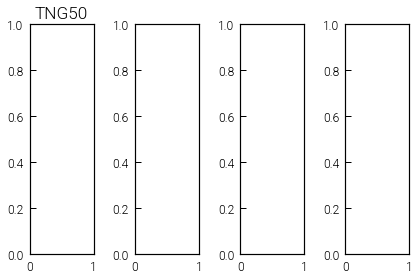

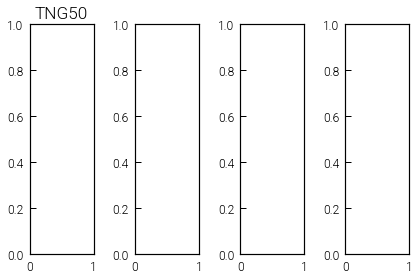

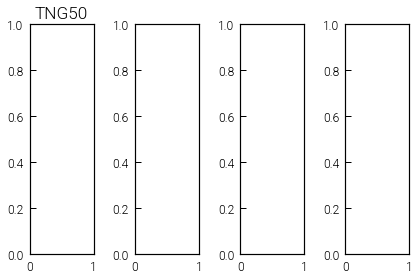

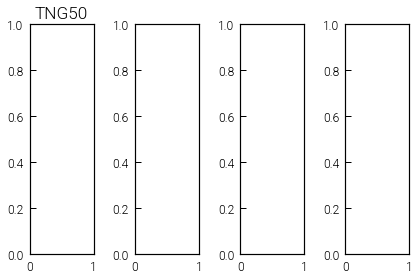

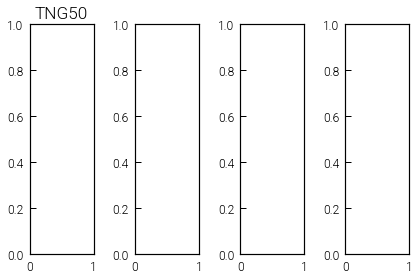

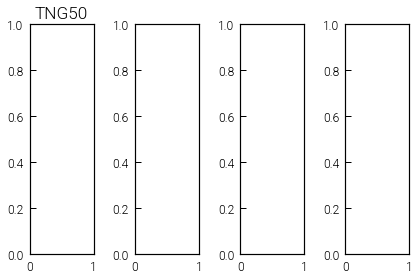

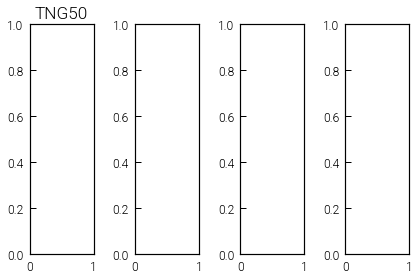

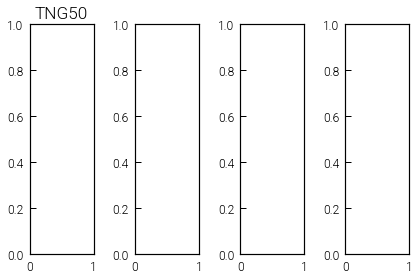

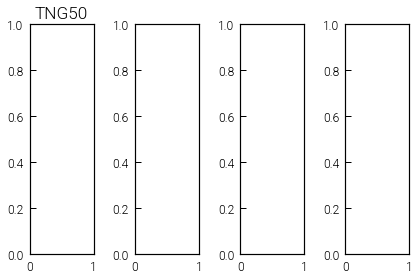

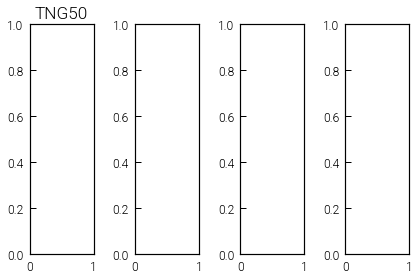

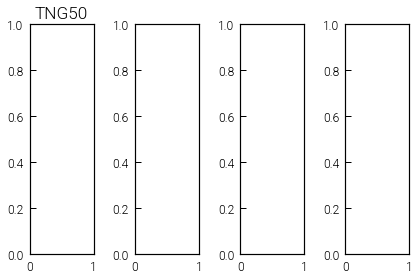

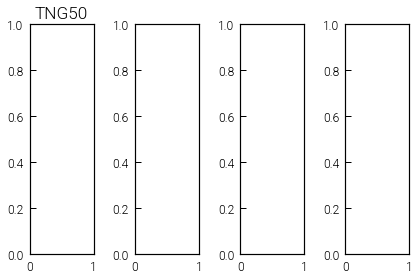

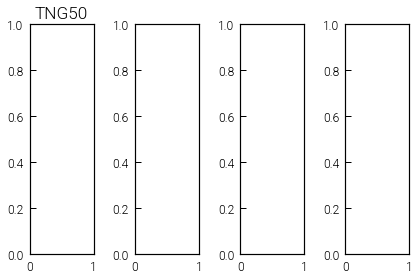

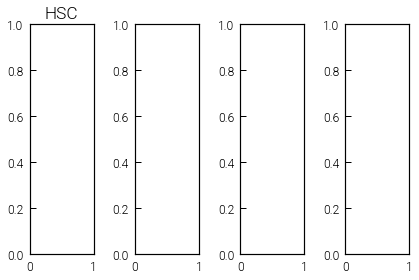

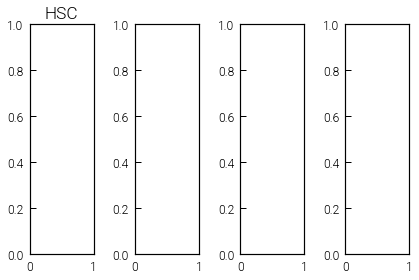

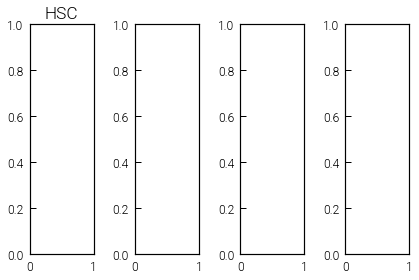

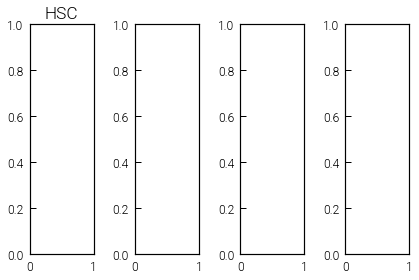

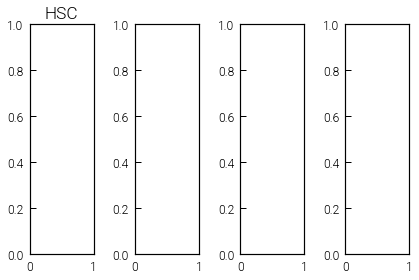

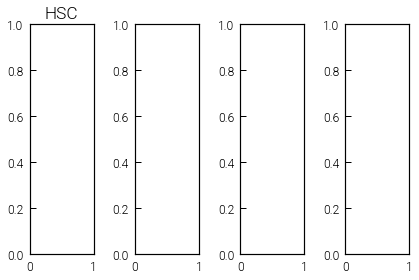

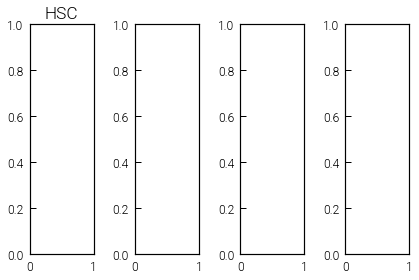

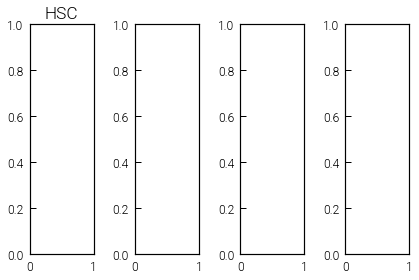

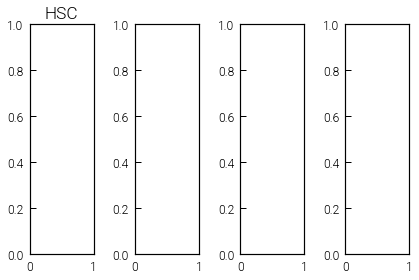

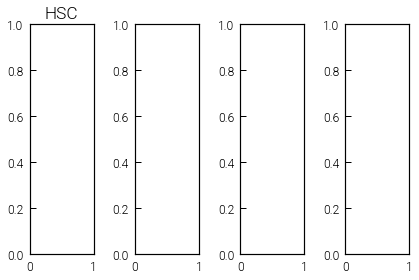

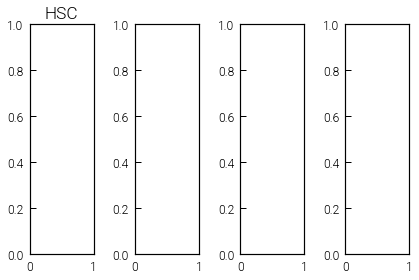

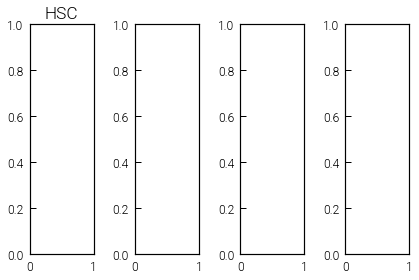

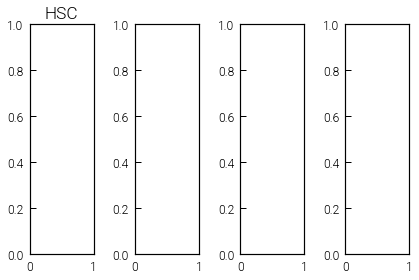

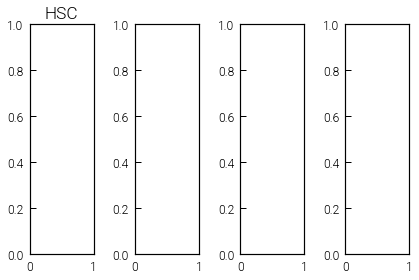

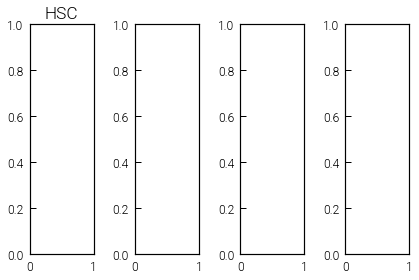

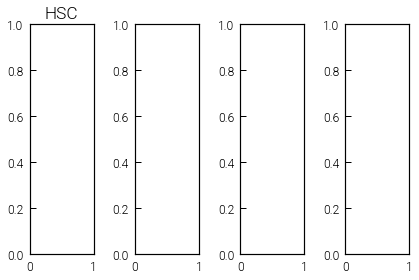

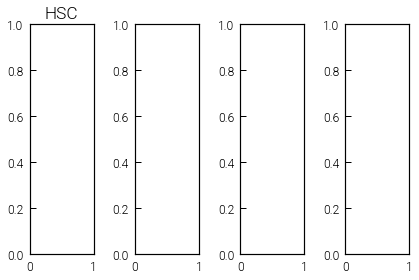

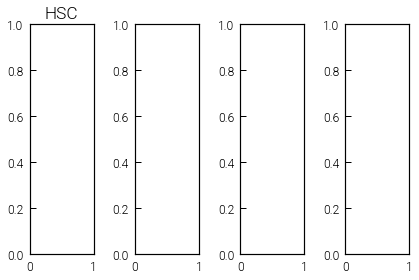

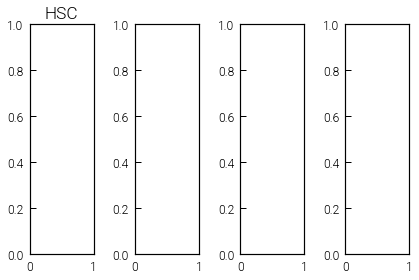

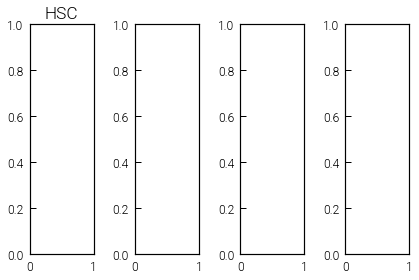

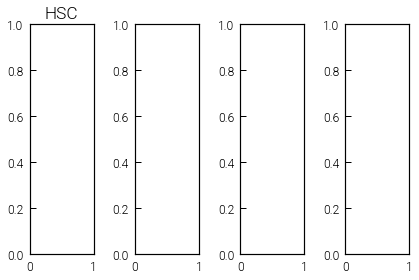

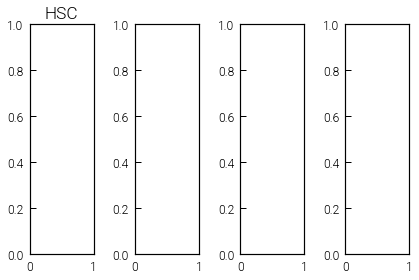

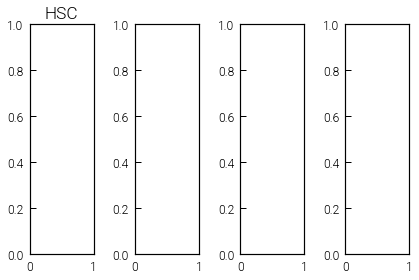

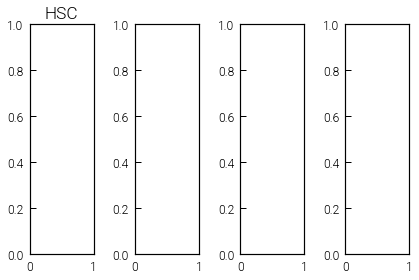

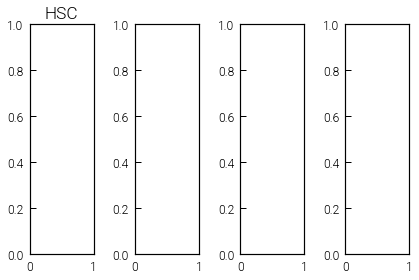

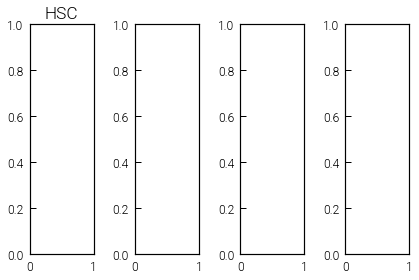

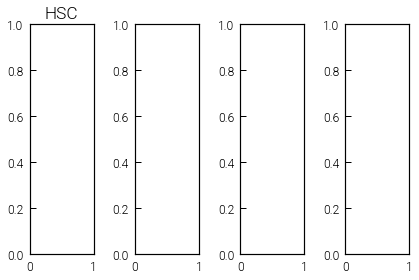

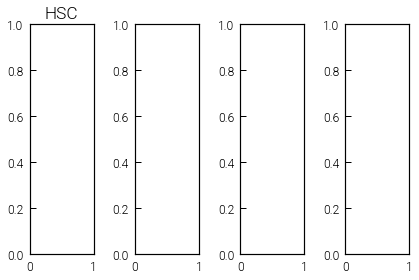

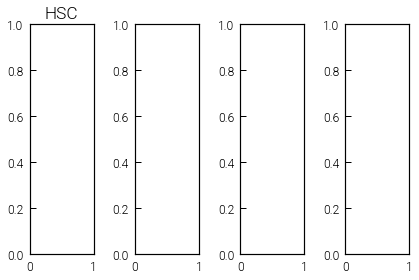

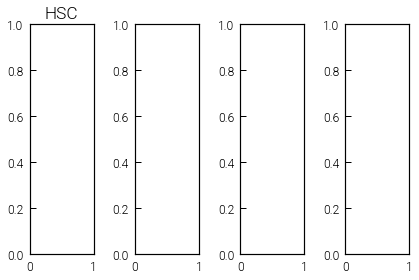

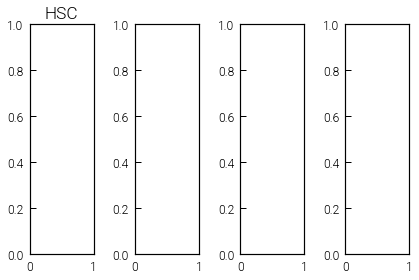

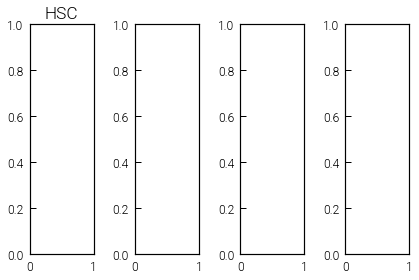

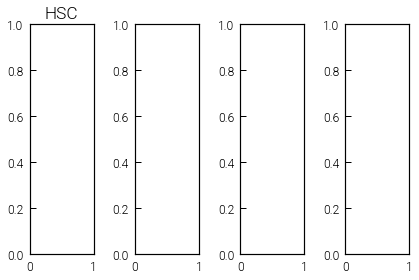

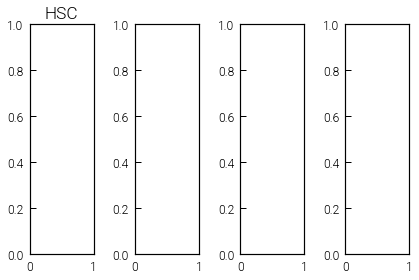

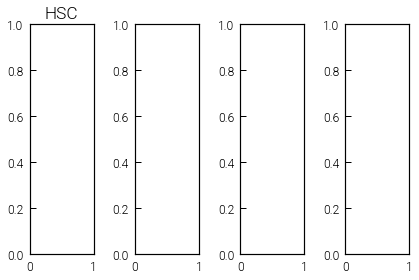

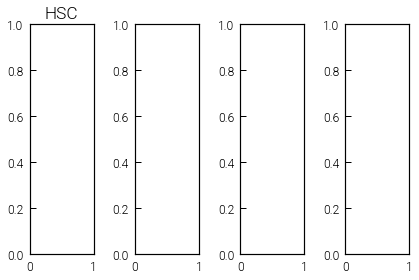

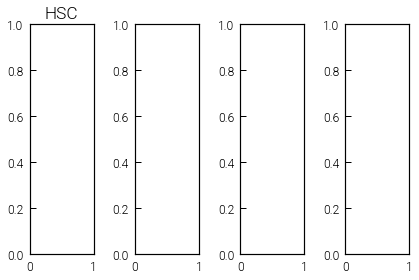

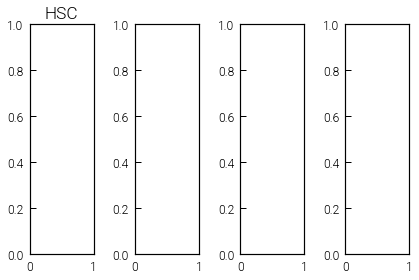

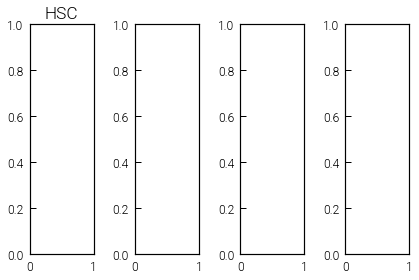

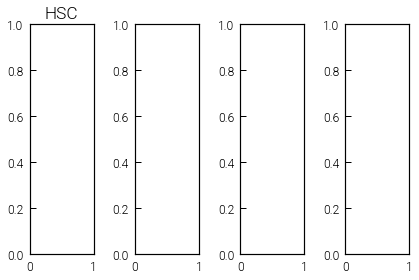

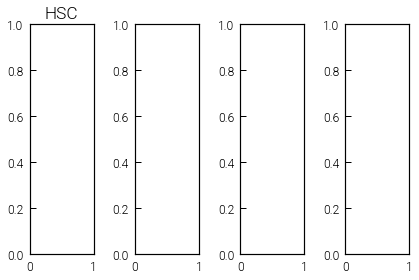

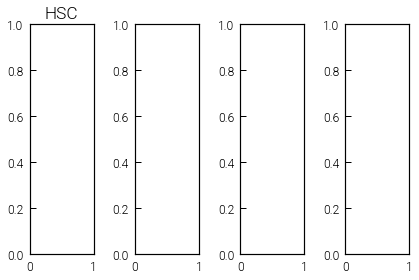

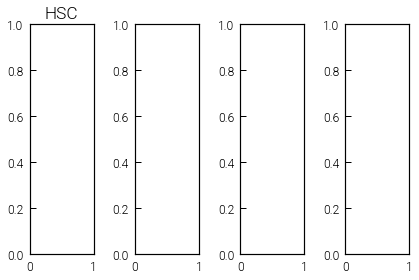

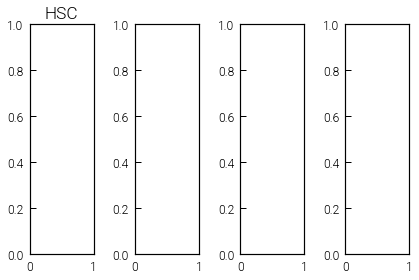

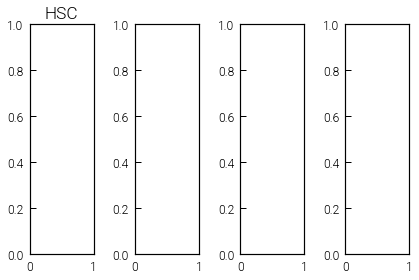

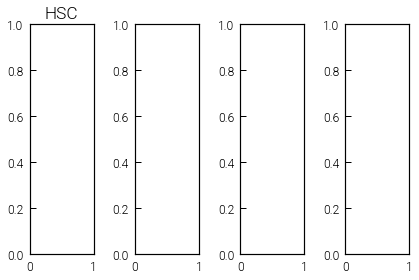

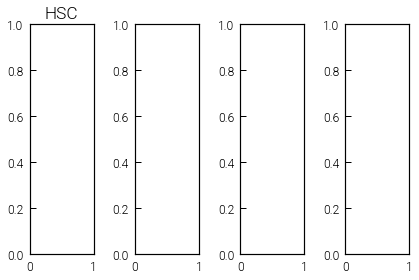

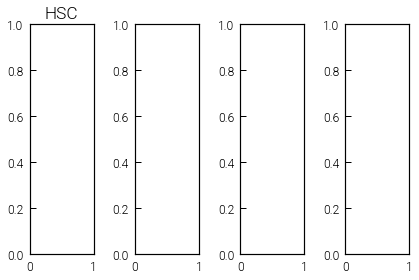

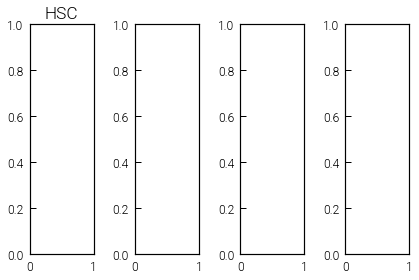

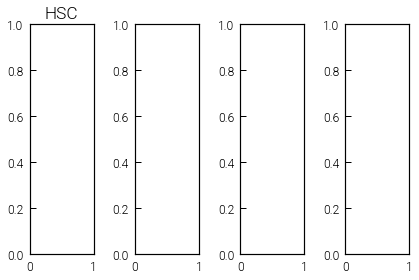

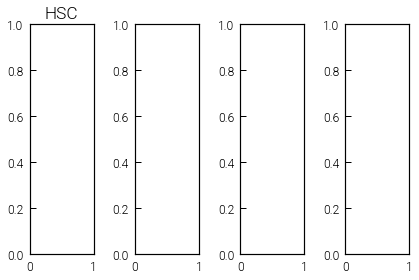

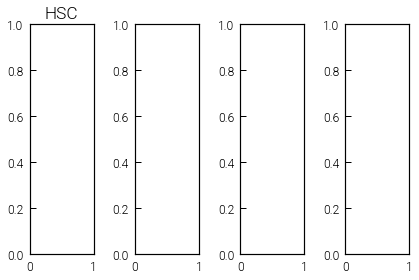

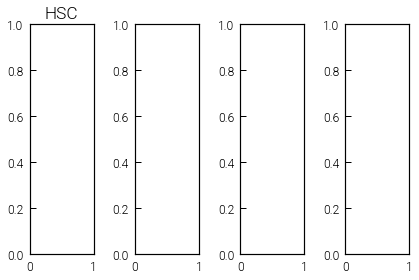

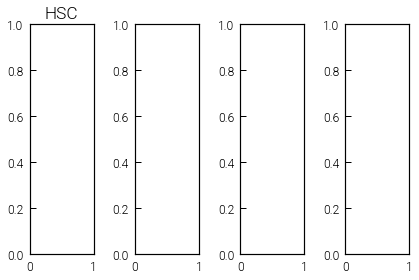

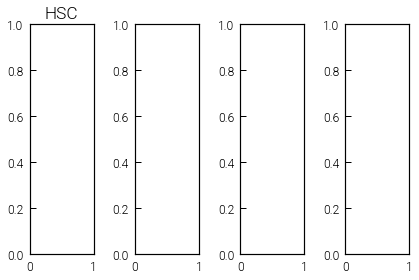

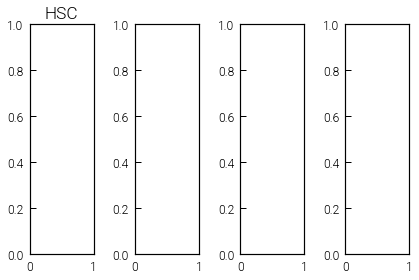

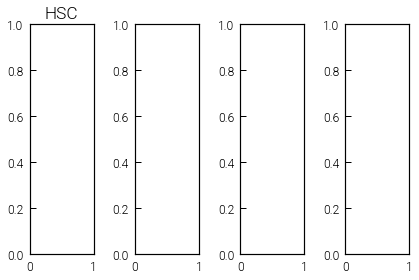

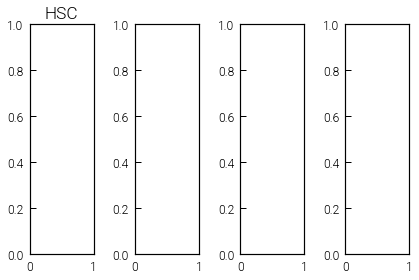

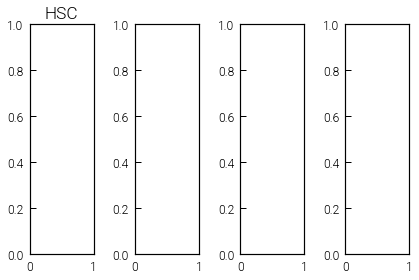

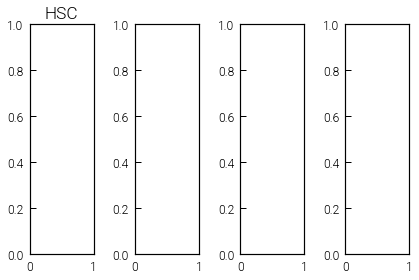

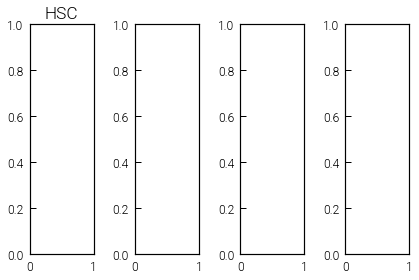

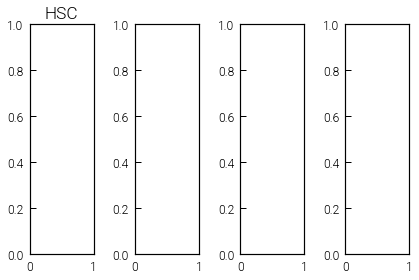

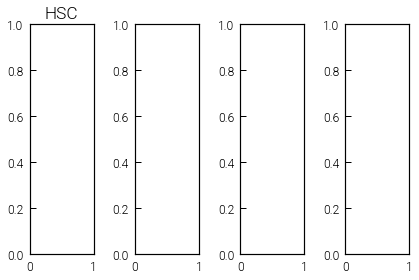

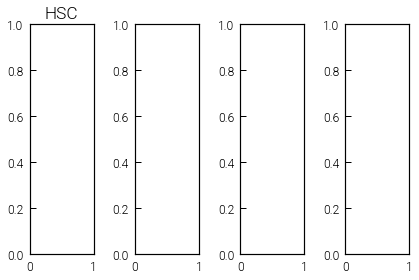

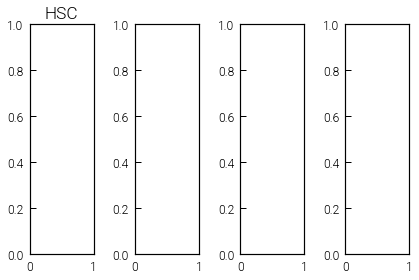

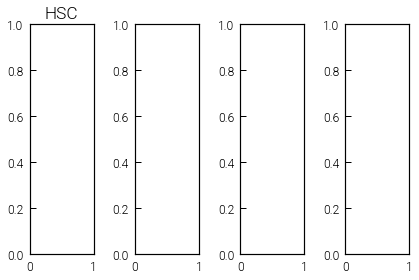

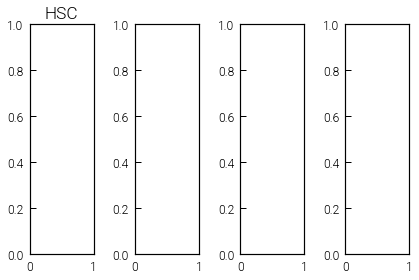

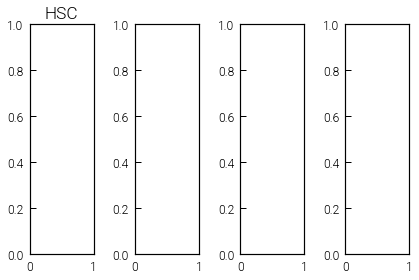

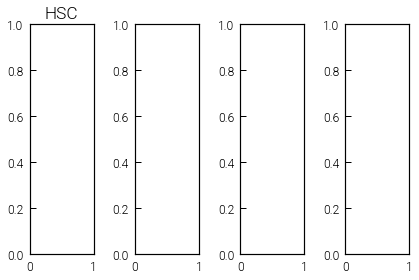

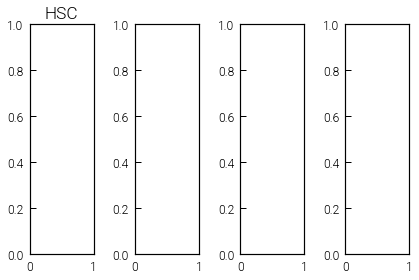

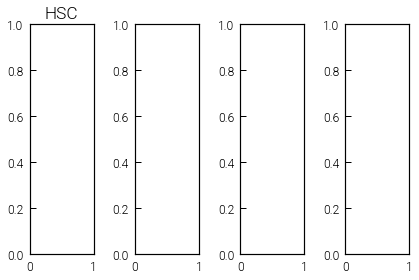

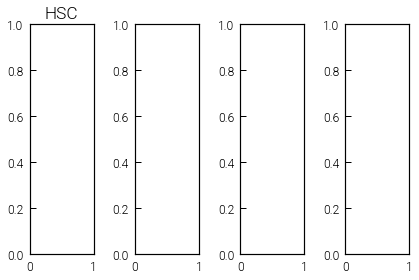

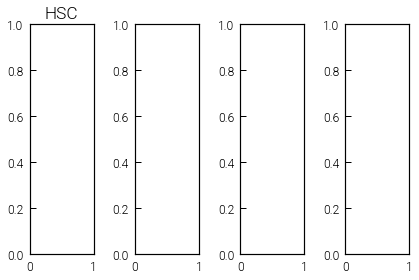

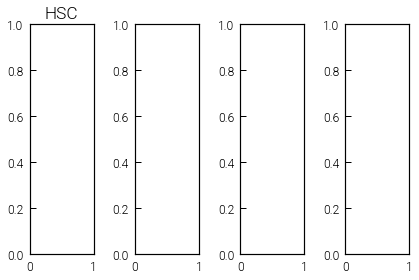

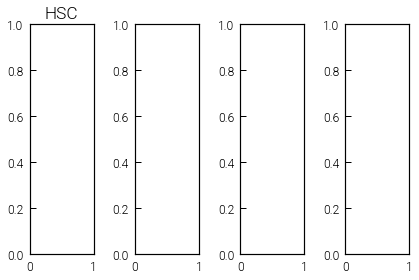

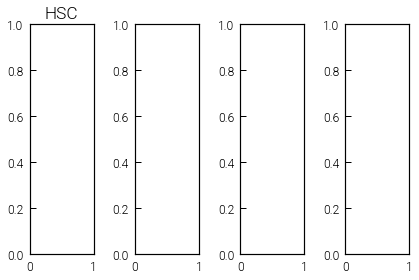

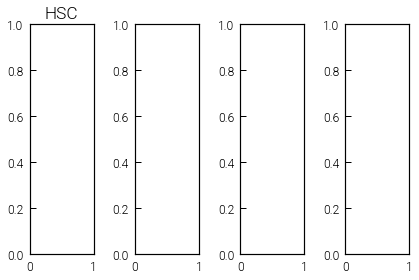

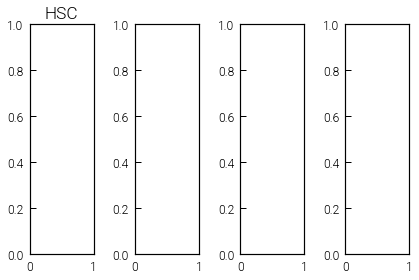

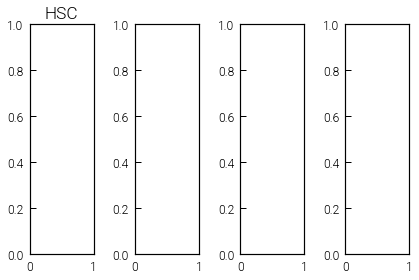

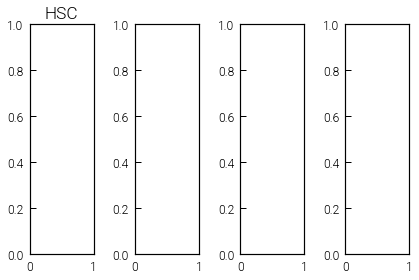

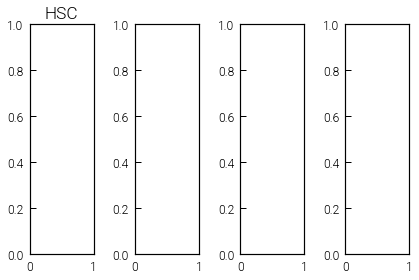

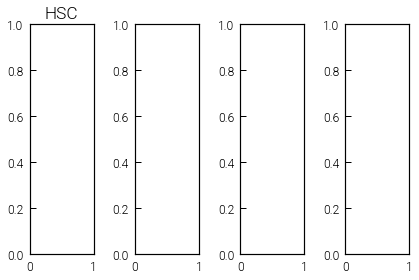

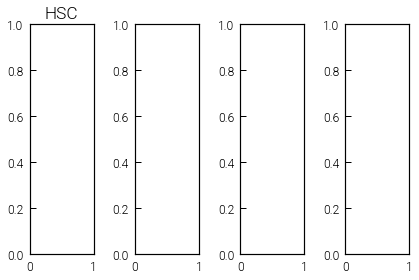

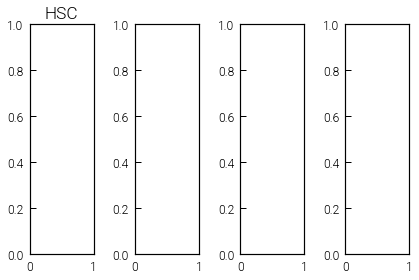

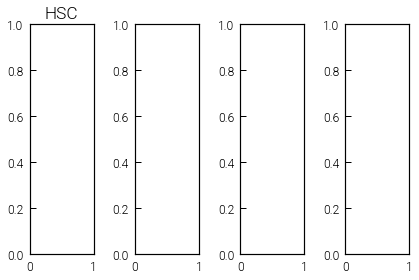

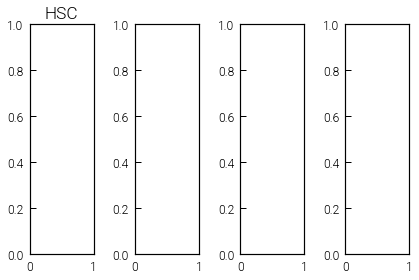

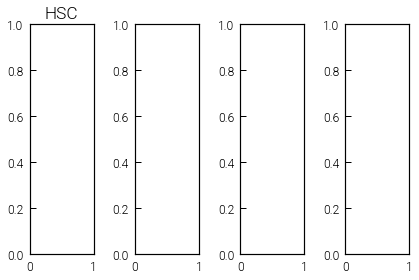

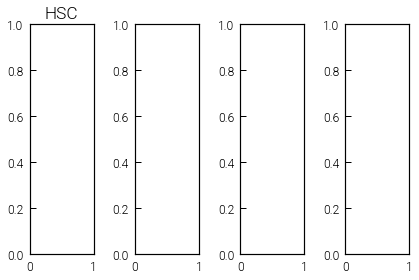

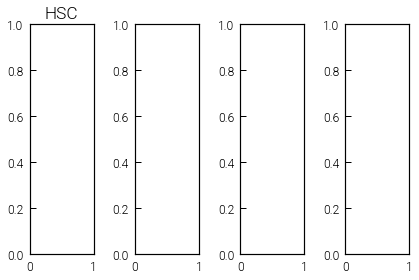

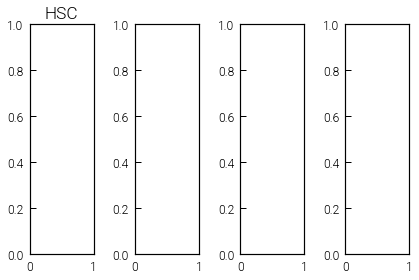

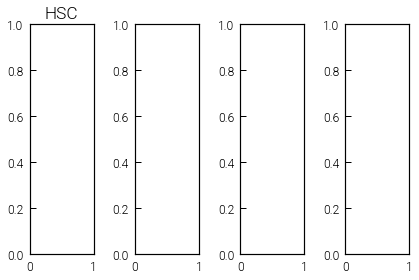

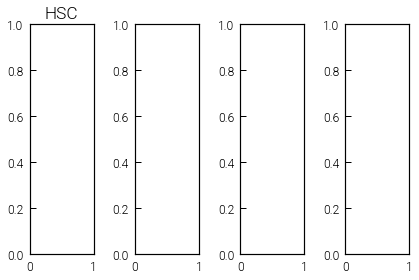

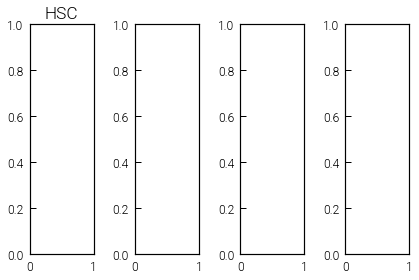

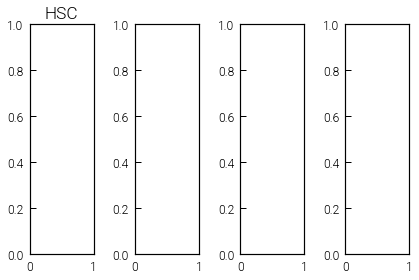

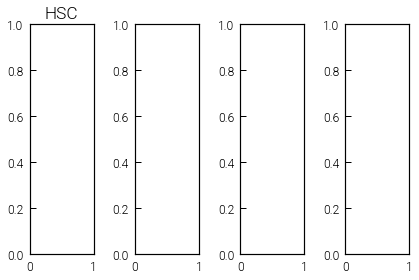

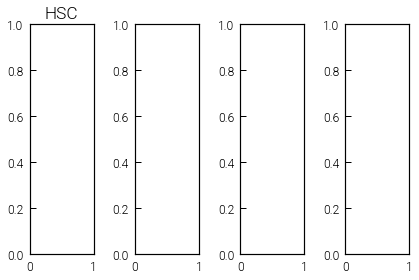

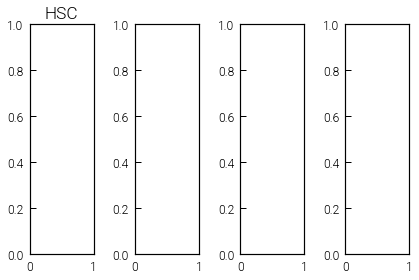

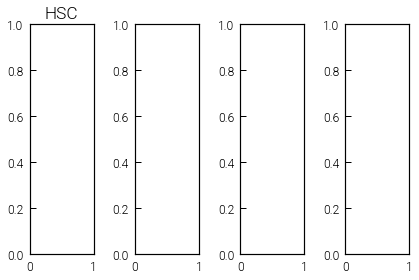

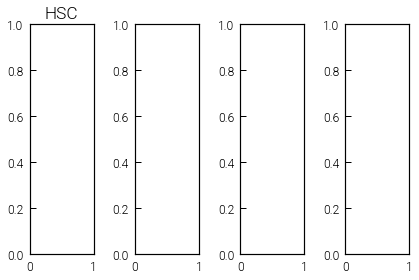

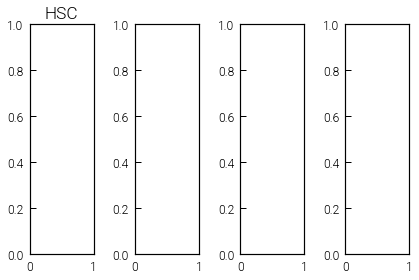

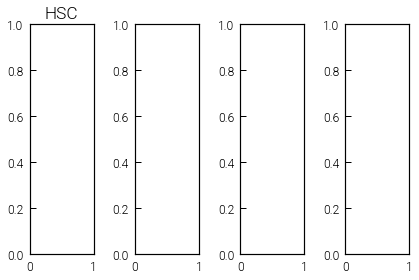

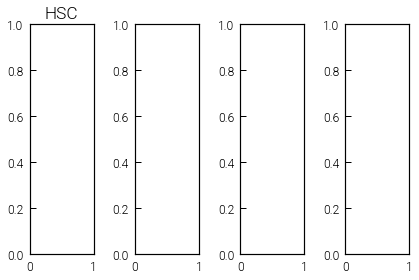

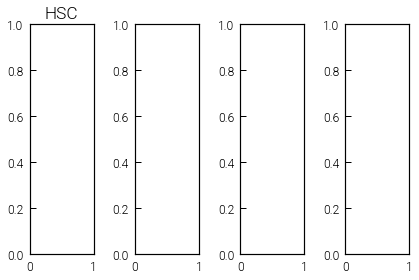

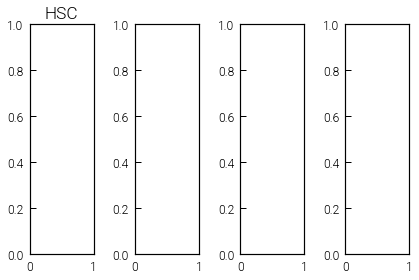

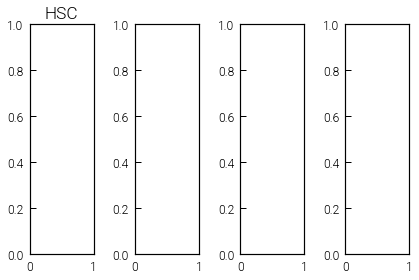

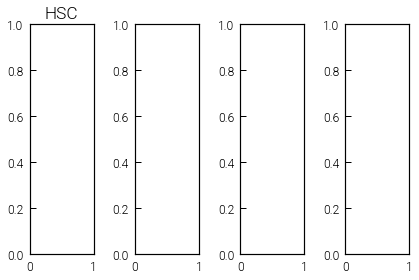

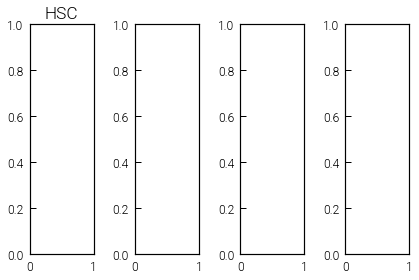

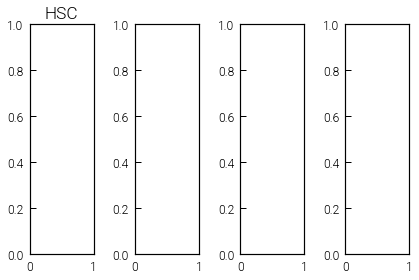

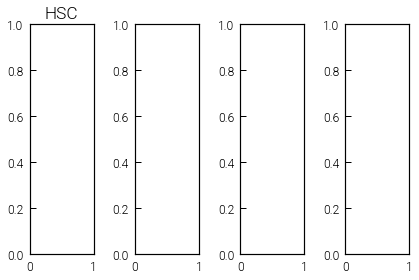

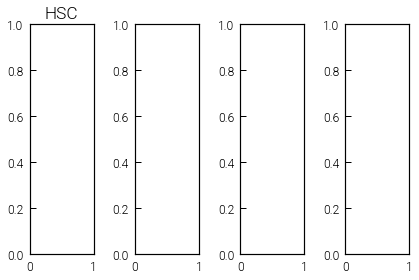

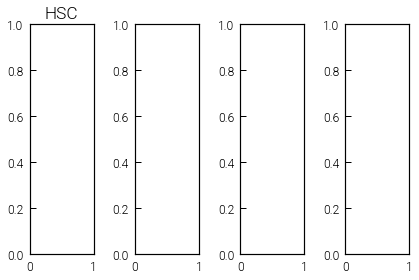

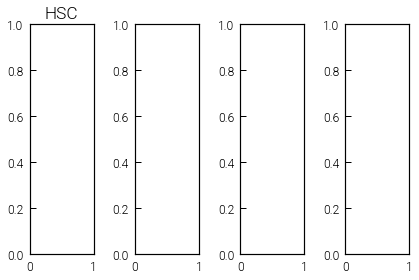

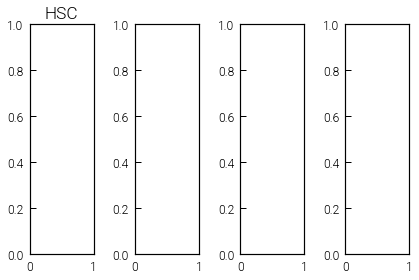

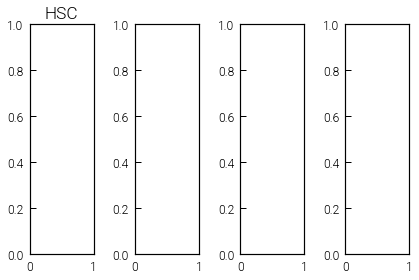

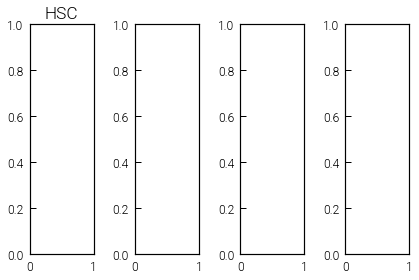

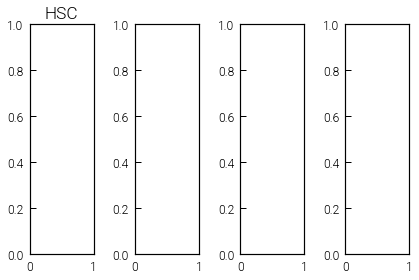

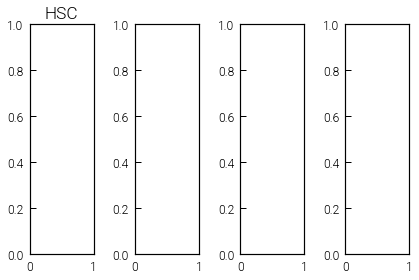

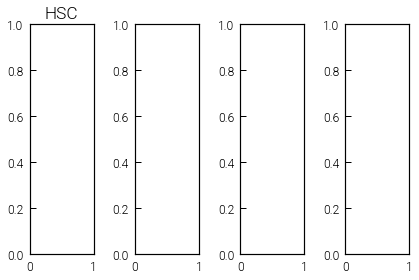

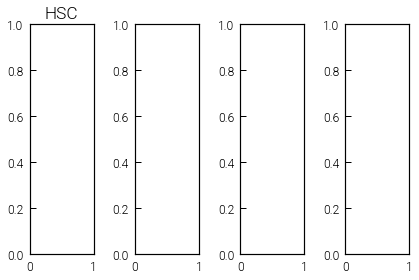

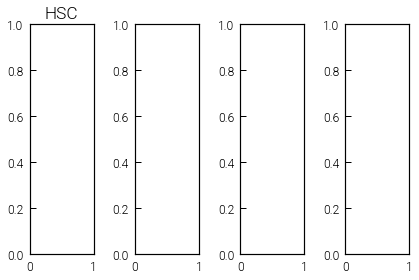

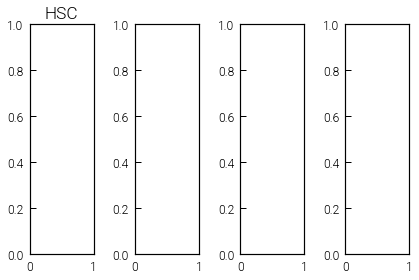

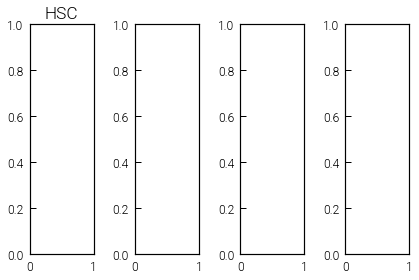

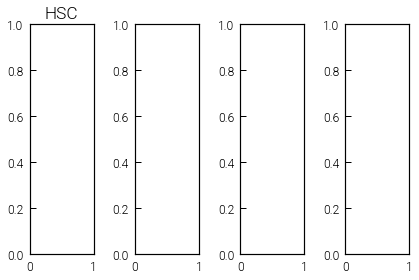

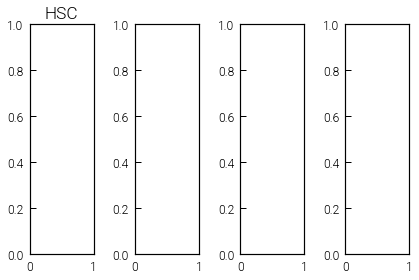

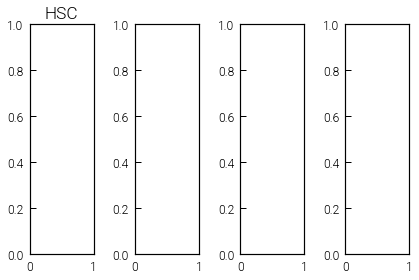

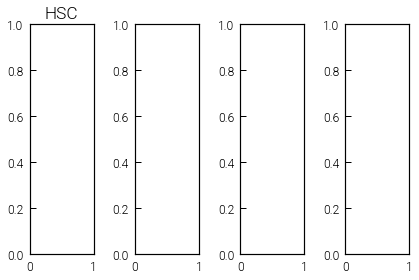

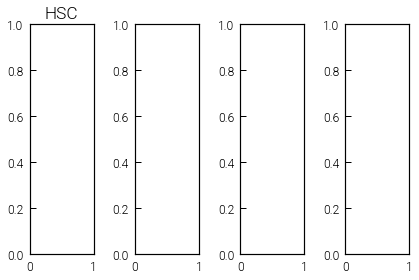

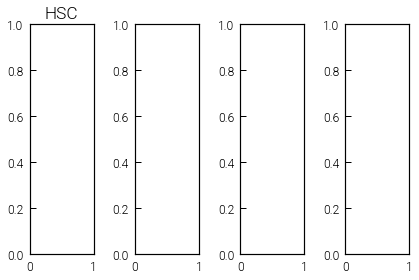

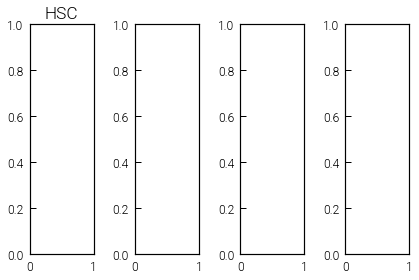

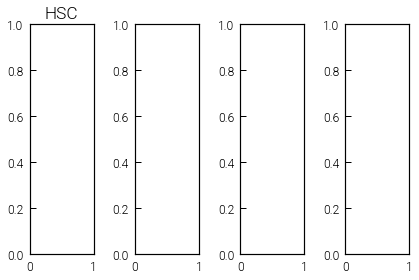

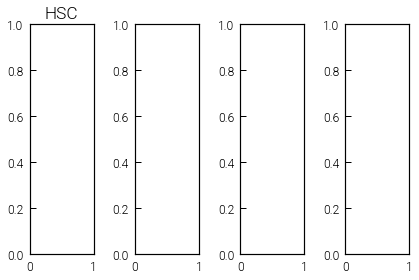

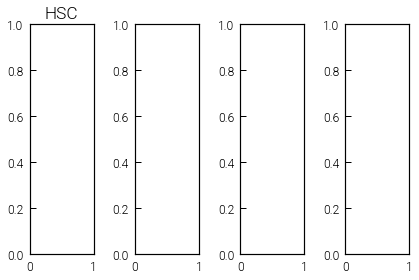

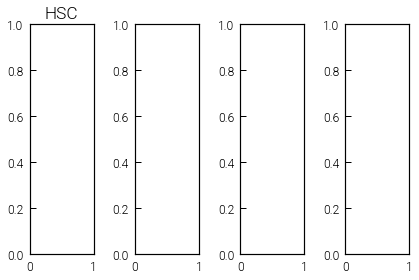

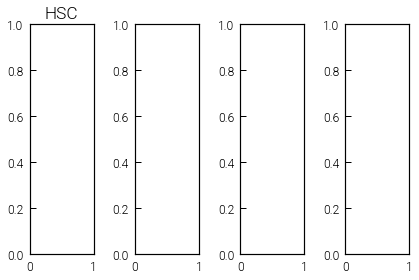

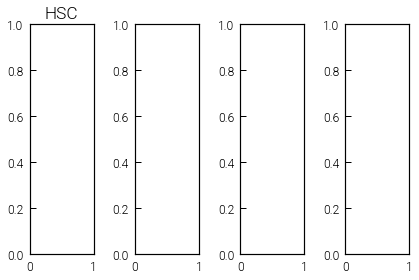

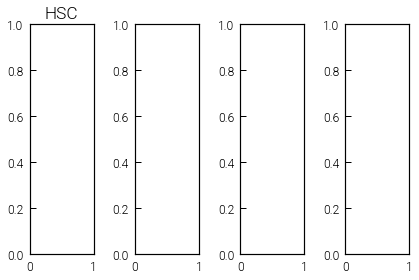

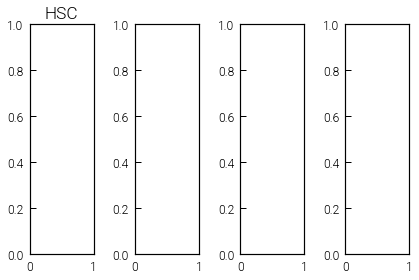

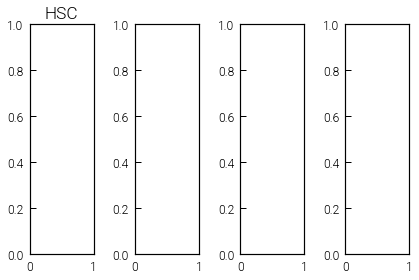

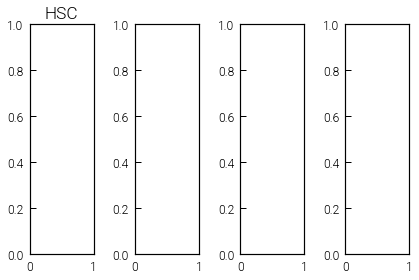

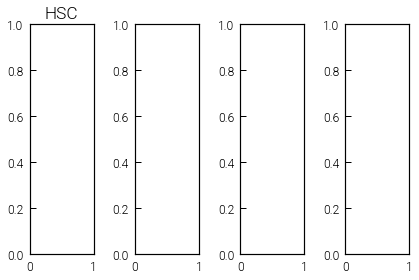

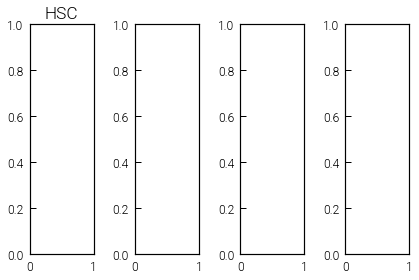

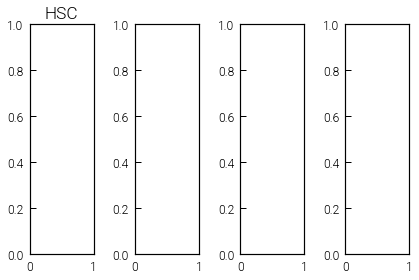

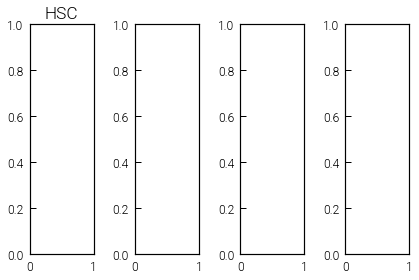

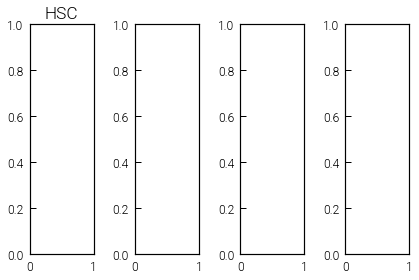

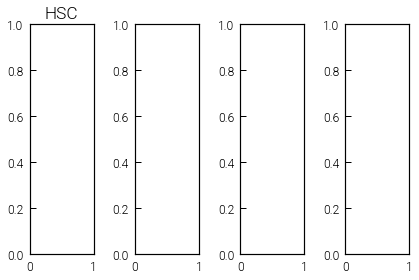

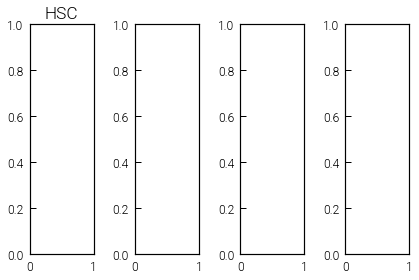

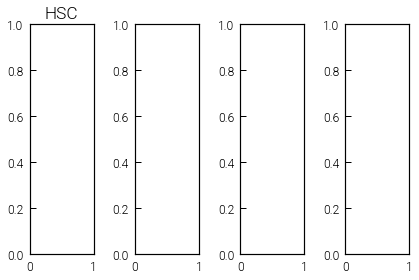

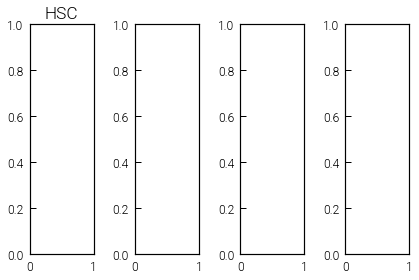

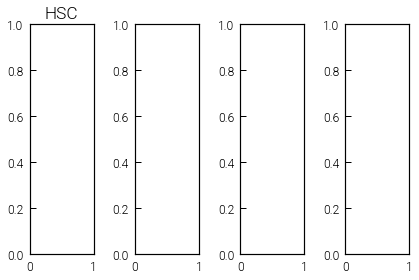

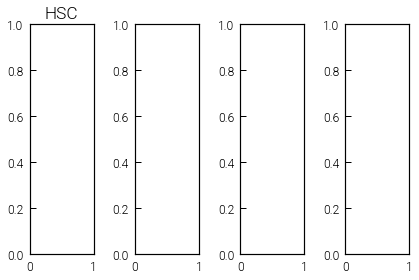

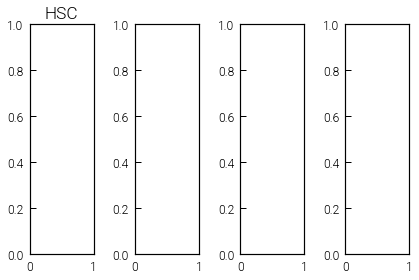

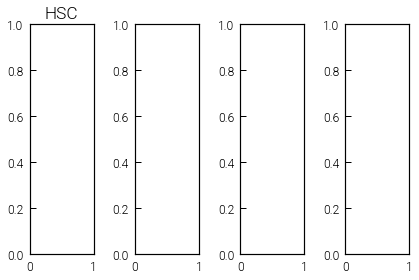

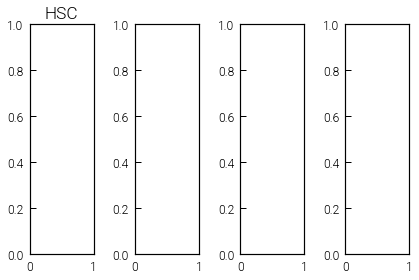

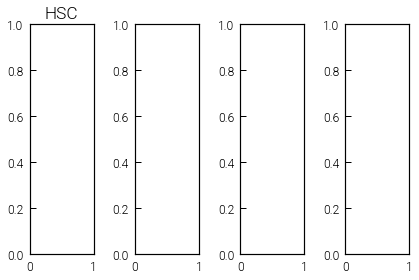

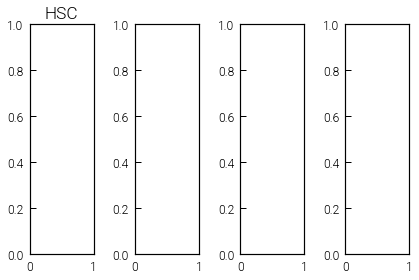

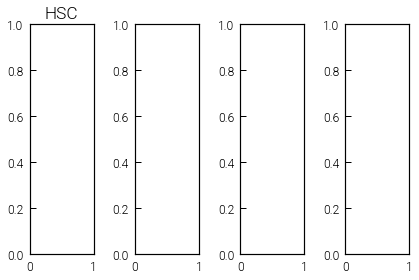

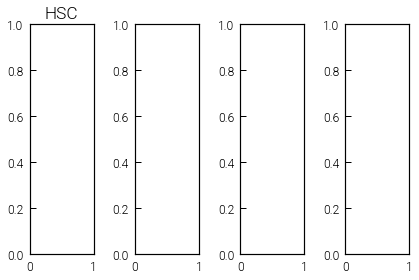

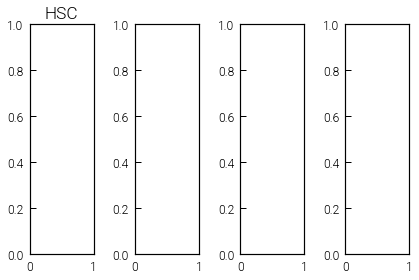

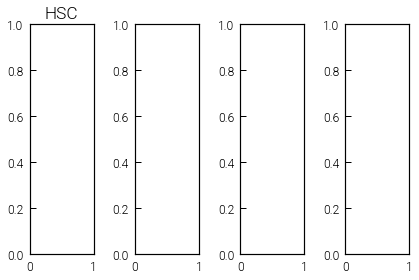

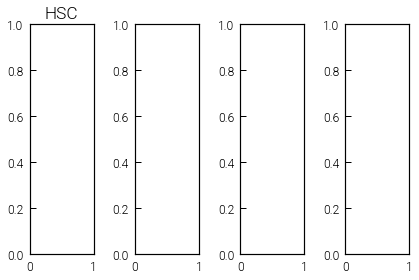

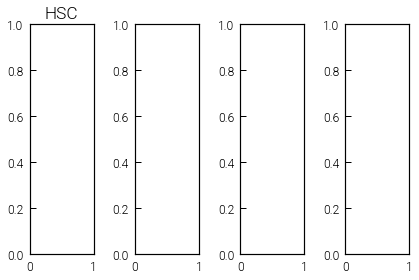

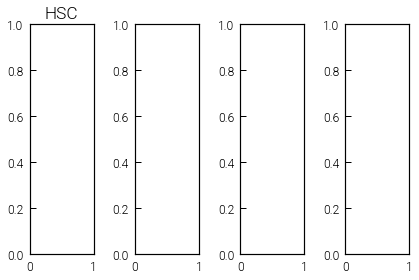

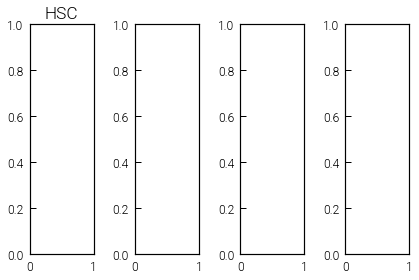

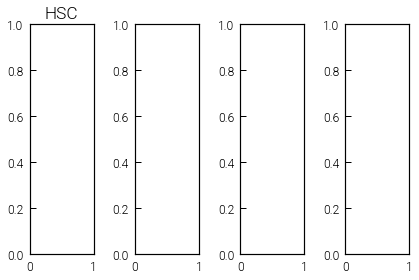

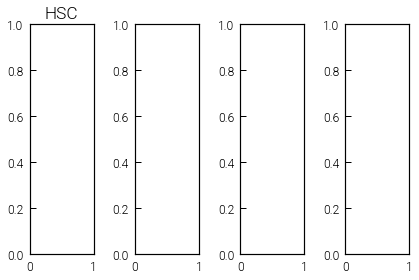

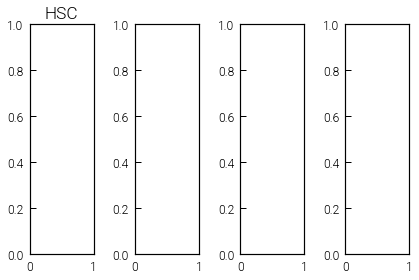

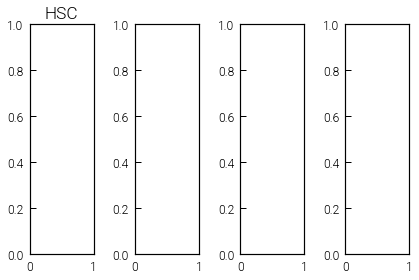

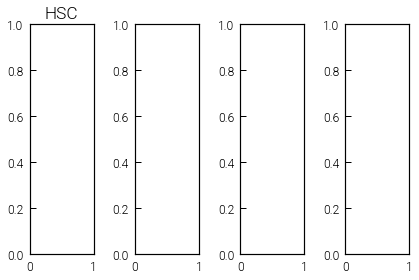

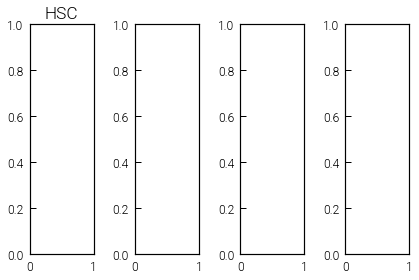

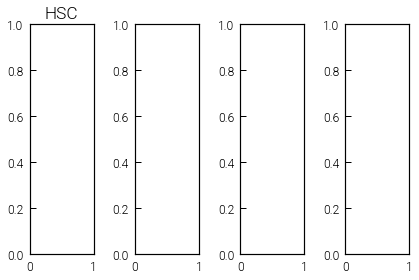

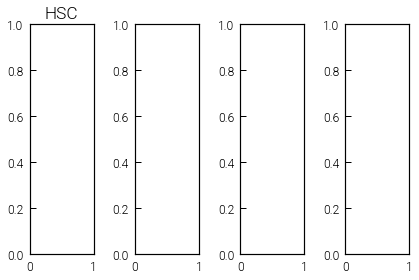

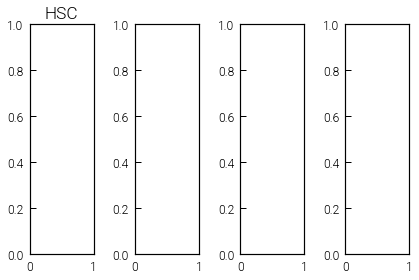

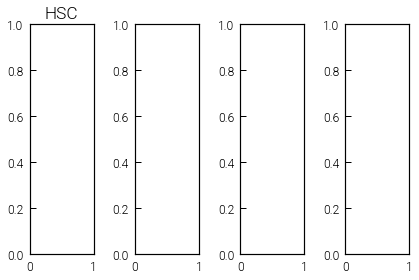

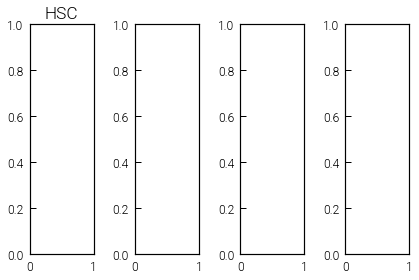

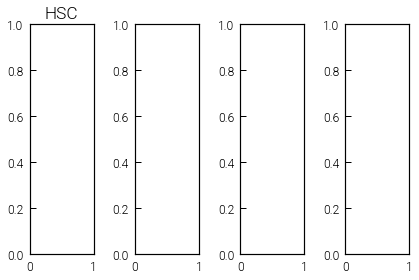

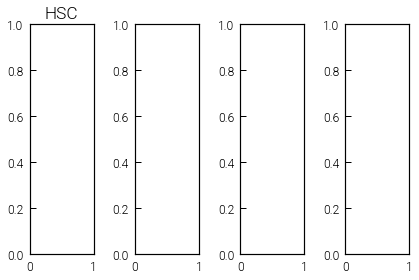

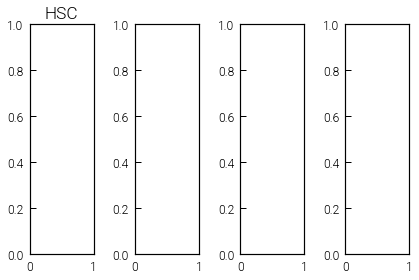

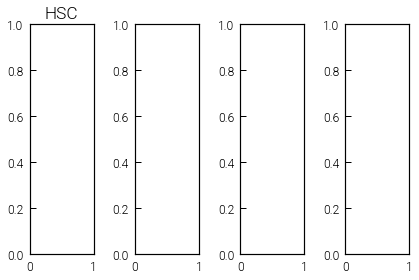

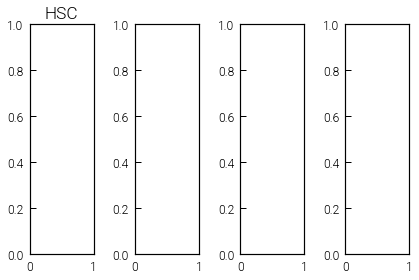

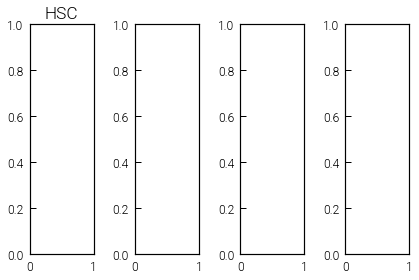

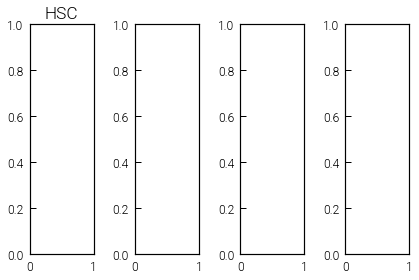

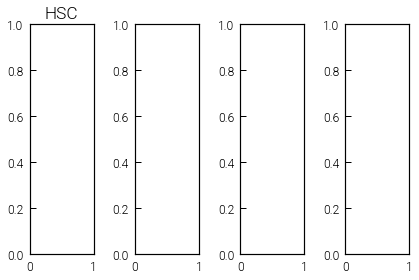

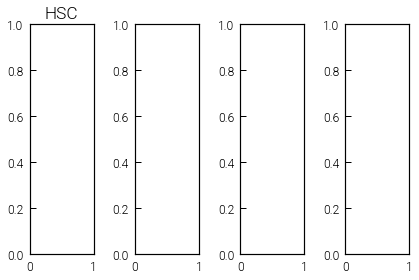

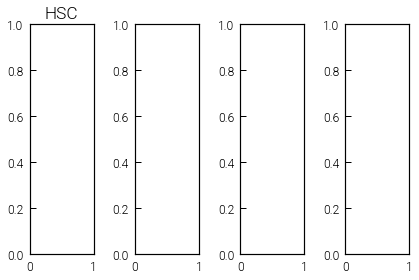

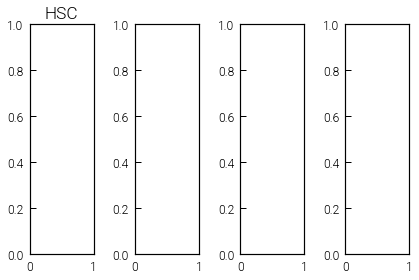

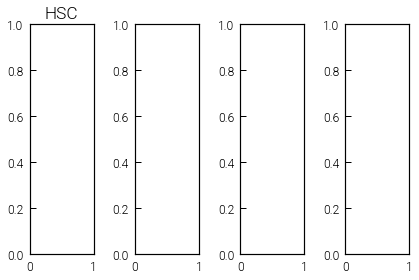

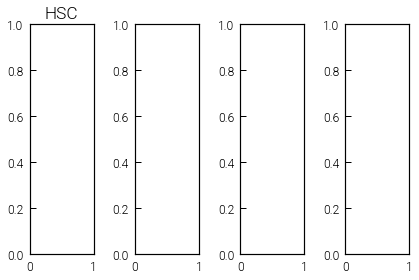

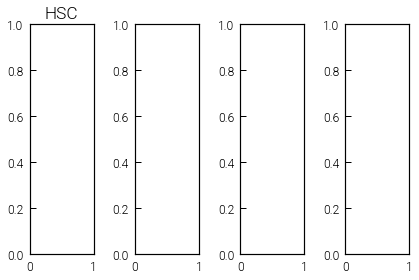

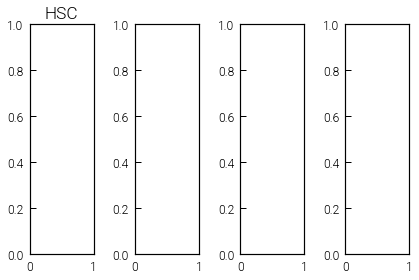

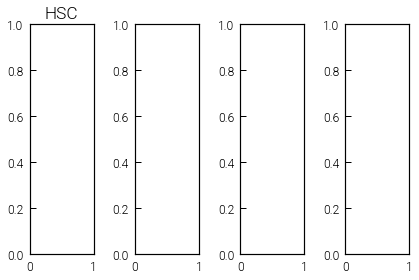

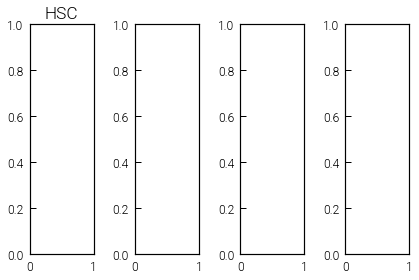

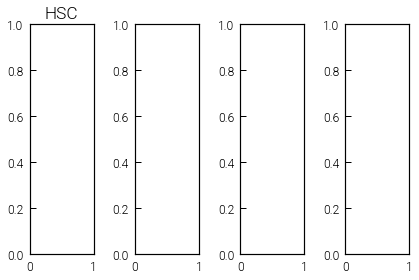

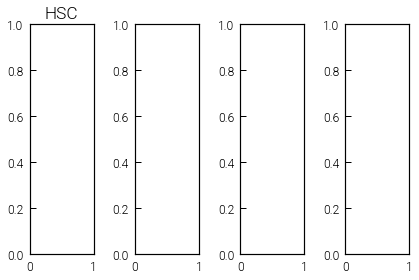

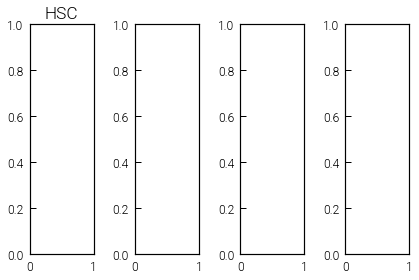

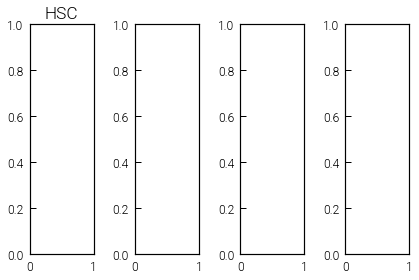

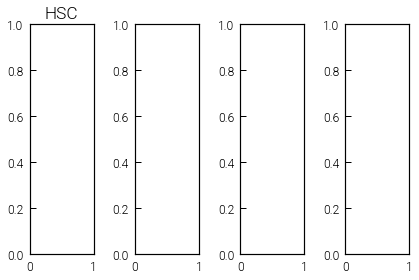

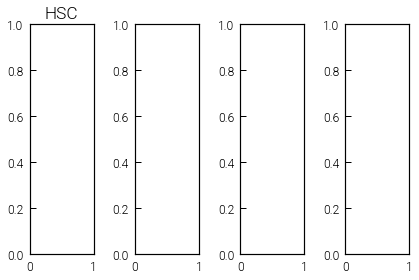

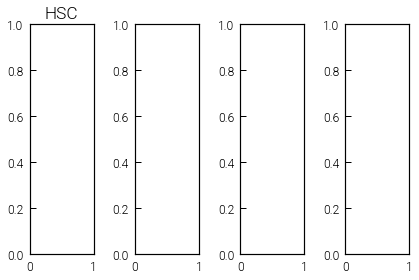

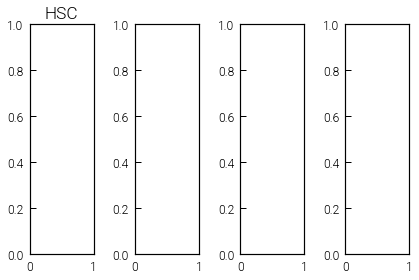

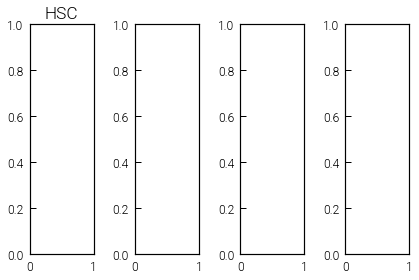

In [15]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import numpy as np
from astropy.io import fits
from tqdm import tqdm

class CounterpartsIdentifier(object):
    def __init__(self, df, dataset1, dataset2):
        #I hardcode the factor here to the TNG set
        self.NORMALIZATION_FACTOR = factor_HSC
        self.N_NEIGHBOR = 8
        self.P = 1
        self.NUM_PAIRS=100
        self.NUM_COUNTERPARTS=3
        
        self.human_label_dict = {'HSC_TNG100': 'TNG100',
                                 'HSC_TNG50': 'TNG50',
                                 'HSC': 'HSC'}
        
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        
        rep1 = self.get_representation(df['dataset'] == dataset1)
        rep2 = self.get_representation(df['dataset'] == dataset2)

        distances, filename1, filename2 = self.get_friends(rep1,
                                                           rep2,
                                                           df['dataset'] == dataset1,
                                                           df['dataset'] == dataset2)
        self.plot(distances, filename1, filename2)


    def load_image(self, filename):

        def get_central_crop(img, num_pixel=20):
            size = img.shape[0]
            center_coordinate = size//2
            upper = center_coordinate + num_pixel//2
            lower = center_coordinate - num_pixel//2

            return img[lower:upper, lower:upper]

        def stretch(x):
            x[x<=0] = np.nan
            x = np.log10(x)
            x[x<-7] = np.nan

            a_min = np.nanmedian(x)
            a_max = np.nanquantile(get_central_crop(x), 0.99)

            x = np.nan_to_num(x, nan=a_min, posinf=a_min, neginf=a_min)
            x = np.clip(x, a_min, a_max)

            x -= a_min
            x /= (a_max - a_min)

            return np.array(x*(2**8 - 1), dtype=np.uint8)

        with fits.open(filename) as hdul:

            G = hdul['G'].data
            R = hdul['R'].data
            I = hdul['I'].data

        G = stretch(G)
        R = stretch(R)
        I = stretch(I)

        return np.concatenate((I[...,np.newaxis],R[...,np.newaxis],G[...,np.newaxis]),axis=2)
    
    
    def get_representation(self, mask):
        with open('./postprocessing/representation.npy', 'rb') as f:
            rep = np.load(f)
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            scaler.fit(rep)
            rep = scaler.transform(rep)

        return rep[mask]
    
    def get_friends(self, rep1, rep2, rep1_mask, rep2_mask):
        '''Get pairs of images which are closest in the representation space'''
        x_list = [rep1, rep2]
        df_list = [df[rep1_mask], df[rep2_mask]]

        x_list, df_list = dt.DistributionTest.reshape_inputs(x_list,df_list)

        rep1 = x_list[0]
        rep2 = x_list[1]
        df1 = df_list[0]
        df2 = df_list[1]

        mnnd = dt.MeanNormalizedNeighborDistance(rep1, n_neighbor=self.N_NEIGHBOR, p=self.P)
        score = mnnd.get_normalized_neighbor_distances(rep2)/self.NORMALIZATION_FACTOR

        tree = cKDTree(rep2, compact_nodes=False, balanced_tree=False)
        image_paths_1 = df1['image_path'].to_numpy()
        image_paths_2 = df2['image_path'].to_numpy()

        scores = []
        filename1 = []
        filename2 = []

        for i in range(self.NUM_PAIRS):
            _, index = tree.query(rep1[i], k=self.NUM_COUNTERPARTS, p=1)
            scores.append(score[i])
            filename1.append("../." + image_paths_1[i])
            
            
            if self.NUM_COUNTERPARTS == 1:
                filename2.append("../." + image_paths_2[index[j]])
            
            else:
                filename_temp = []
                for j in range(self.NUM_COUNTERPARTS):
                    filename_temp.append("../." + image_paths_2[index[j]])

                filename2.append(filename_temp)

        return np.array(scores), np.array(filename1), np.array(filename2)
    
    def plot(self, distances, filename1, filename2):
        
        #Sort according to distances
        sort_index = np.argsort(distances)
        distances = distances[sort_index]
        filename1 = filename1[sort_index]
        filename2 = filename2[sort_index]

        for i, (d, f1, f2) in tqdm(enumerate(zip(distances, filename1, filename2))):

            fig, axes = plt.subplots(1, self.NUM_COUNTERPARTS+1)
            
            #The image counterparts are searched for
            ax1 = axes[0]
            ax1.set_title(self.human_label_dict[self.dataset1])
            
            try:
                im1 = self.load_image(f1)
            except FileNotFoundError as e:
                print(e)
                continue
                
            ax1.imshow(im1)
            ax1.annotate(f'Score: {d:.2f}', (0.25,0.1),
                    ha="center", va="center", size=15, xycoords='axes fraction',
                    bbox=dict(boxstyle="Square,pad=0.3", fc="white", ec="black", lw=2))

            ax1.axis('off')
            
            
            #The counterparts
            for j, axj in enumerate(axes[1:]):
                    
                axj.set_title(self.human_label_dict[self.dataset2])
            
                if self.NUM_COUNTERPARTS == 1:
                    f = f2
                else:
                    f = f2[j]
            
                try:
                    im = self.load_image(f)
                except FileNotFoundError as e:
                    print(e)
                    continue

                axj.imshow(im)
                axj.axis('off')

            plt.savefig(f'./temp/images/friends_{self.dataset1}_{self.dataset2}_{i:05}.pdf')
            #plt.show()
            
CounterpartsIdentifier(df, 'HSC_TNG100', 'HSC')
CounterpartsIdentifier(df, 'HSC_TNG50', 'HSC')
CounterpartsIdentifier(df, 'HSC', 'HSC_TNG100')
CounterpartsIdentifier(df, 'HSC', 'HSC_TNG50')

In [16]:
TNG_mask = np.logical_or(df['dataset']=='HSC_TNG100', df['dataset']=='HSC_TNG50')
rep_TNG = rep[TNG_mask]
df_TNG = df[TNG_mask].copy()
mass = df_TNG['mass'].to_numpy()

tree = cKDTree(rep_TNG, compact_nodes=False, balanced_tree=False)
std = []
mm = []
mmd = []
for r in tqdm(rep_TNG):
    d, index = tree.query(r, k=8, p=1)
    m = []
    for i in index:
        m.append(mass[i])
    std.append(np.std(m))
    mm.append(np.max(m)-np.min(m))
    mmd.append((np.max(m)-np.min(m))/d[7])

100%|██████████| 31617/31617 [04:22<00:00, 120.65it/s]


(array([1.967e+03, 8.163e+03, 7.921e+03, 5.645e+03, 3.376e+03, 1.941e+03,
        1.109e+03, 6.220e+02, 3.520e+02, 1.860e+02, 1.360e+02, 6.000e+01,
        4.300e+01, 3.900e+01, 2.300e+01, 1.500e+01, 1.100e+01, 3.000e+00,
        3.000e+00, 2.000e+00]),
 array([0.00363729, 0.02782665, 0.05201601, 0.07620537, 0.10039473,
        0.12458409, 0.14877346, 0.17296282, 0.19715218, 0.22134154,
        0.2455309 , 0.26972026, 0.29390963, 0.31809899, 0.34228835,
        0.36647771, 0.39066707, 0.41485643, 0.4390458 , 0.46323516,
        0.48742452]),
 <BarContainer object of 20 artists>)

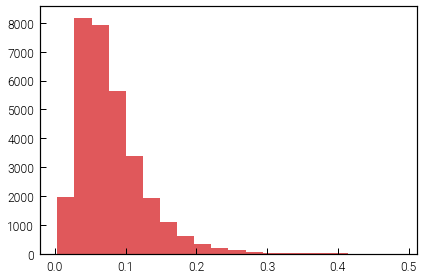

In [17]:
plt.hist(mmd, bins=20)